In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn.utils import clip_grad_norm_

torch.manual_seed(2024)
HIDDEN_DIM = 256
USE_SIGMA = 1
device = torch.device("cpu")

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

class ForwardModel(nn.Module):
    def __init__(self, hidden_dim=128, use_sigma=True):
        super(ForwardModel, self).__init__()
        self.use_sigma = use_sigma
        self.hidden_dim = hidden_dim

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.max_pool = nn.MaxPool2d(2)

        # Linear layers
        self.fc1 = nn.Linear(32 * 7 * 7, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 10)

        self.LN1 = nn.LayerNorm((32, 14, 14), elementwise_affine=False)
        self.LN2 = nn.LayerNorm((1, 28, 28), elementwise_affine=False)

        self.fc2.weight.data.zero_()
        self.fc2.bias.data.zero_()
        self.fc1.bias.data.zero_()
        self.conv2.bias.data.zero_()
        self.conv1.bias.data.zero_()

    def forward(self, x):
        
        x = x.view(-1, 1, 28, 28)
        x = self.LN2(x)

        a1 = F.elu(self.conv1(x.detach()))
        a1 = self.max_pool(a1)
        a1 = self.LN1(a1)

        a2 = F.elu(self.conv2(a1.detach()))
        a2 = self.max_pool(a2)
        a2 = a2.view(-1, 32 * 7 * 7)

        a3 = F.elu(self.fc1(a2.detach()))

        a4 = self.fc2(a3.detach())
        self.penultimate_feature = a3.detach()

        return a1, a2, a3, a4

    def forward_logits(self):
        return self.fc2(self.penultimate_feature)

class BackwardModel(nn.Module):
    def __init__(self, hidden_dim=128):
        super(BackwardModel, self).__init__()
        self.hidden_dim = hidden_dim

        self.fc1 = nn.Linear(10, hidden_dim, bias=False)
        self.fc2 = nn.Linear(hidden_dim, 32 * 7 * 7, bias=False)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv1 = nn.Conv2d(32, 32, kernel_size=5, padding=2, bias=False)
        self.LN1 = nn.LayerNorm((32, 14, 14), elementwise_affine=False)

    def forward(self, t, use_act_derivative=False):
        device = t.device
        t = F.one_hot(t, num_classes=10).float().to(device)
        if use_act_derivative:
            s3 = F.elu(self.fc1(t.detach()) * a3.sign().detach())
            s2 = F.elu(self.fc2(s3.detach()) * a2.sign().detach())
            s2_ = s2.view(-1, 32, 7, 7)
            s2_ = self.upsample1(s2_)
            s1 = F.elu(self.conv1(s2_.detach()) * a1.sign().detach())
        else:
            s3 = F.elu(self.fc1(t.detach()))
            # s3 = s3 - s3.mean()
            s2 = F.elu(self.fc2(s3.detach()))
            # s2 = s2 - s2.mean()
            s2_ = s2.view(-1, 32, 7, 7)
            s2_ = self.upsample1(s2_)
            s1 = F.elu(self.conv1(s2_.detach()))
        return s1, s2, s3

def normal(x): return x / x.std()

def sigma_loss(a1, a2, a3, a4, s1, s2, s3, t):

    loss1 = F.mse_loss(normal(a1), normal(s1))
    loss2 = F.mse_loss(normal(a2), normal(s2))
    loss3 = F.mse_loss(normal(a3), normal(s3))
    loss4 = criteria(a4, t)
    loss = loss1 + loss2 + loss3 + loss4
    return loss, loss1.item(), loss2.item(), loss3.item(), loss4.item()

# Initialize the models
forward_model = ForwardModel(use_sigma=USE_SIGMA)
backward_model = BackwardModel()

forward_model.to(device)
backward_model.to(device)

# Define the optimizers
# forward_optimizer = optim.SGD(forward_model.parameters(), lr=0.01, weight_decay=0.01, momentum=0.5)
# backward_optimizer = optim.SGD(backward_model.parameters(), lr=0.001)
forward_optimizer = optim.RMSprop(forward_model.parameters(), lr=0.0001)
backward_optimizer = optim.RMSprop(backward_model.parameters(), lr=0.0000005)
criteria = nn.CrossEntropyLoss()

for epoch in range(30):
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # data = data * 0.5 + 0.5
        
        if batch_idx > 100: continue

        data, target = data.to(device), target.to(device)
        a1, a2, a3, a4 = forward_model(data)
        s1, s2, s3 = backward_model(target, use_act_derivative=False)
        loss, l1, l2, l3, l4 = sigma_loss(a1, a2, a3, a4, s1, s2, s3, target)

        # Update parameters
        forward_optimizer.zero_grad()
        backward_optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(backward_model.parameters(), 0.1)
        forward_optimizer.step()
        backward_optimizer.step()
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        if batch_idx > 200: continue

        data, target = data.to(device), target.to(device)
        a1, a2, a3, a4 = forward_model(data)
        s1, s2, s3 = backward_model(target, use_act_derivative=False)
        loss = criteria(a4, target)
        # Update parameters
        forward_optimizer.zero_grad()
        loss.backward()
        forward_optimizer.step()
        
    print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss1: {l1*100:.1f}, Loss2: {l2*100:.1f}, Loss3: {l3*100:.1f}, Loss4: {l4:.1f}')
    
    forward_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            # data = data * 0.5 + 0.5
            data, target = data.to(device), target.to(device)
            _, _, _, outputs = forward_model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    print(f'Epoch: {epoch}, Test Accuracy: {100 * correct / total}%')
    forward_model.train()

Epoch: 0, Batch: 1874, Loss1: 198.9, Loss2: 184.8, Loss3: 61.1, Loss4: 2.2
Epoch: 0, Test Accuracy: 87.75%
Epoch: 1, Batch: 1874, Loss1: 196.4, Loss2: 179.0, Loss3: 42.1, Loss4: 1.8
Epoch: 1, Test Accuracy: 90.56%
Epoch: 2, Batch: 1874, Loss1: 196.5, Loss2: 178.3, Loss3: 46.8, Loss4: 1.5
Epoch: 2, Test Accuracy: 92.82%
Epoch: 3, Batch: 1874, Loss1: 194.0, Loss2: 177.5, Loss3: 35.5, Loss4: 1.2
Epoch: 3, Test Accuracy: 93.9%
Epoch: 4, Batch: 1874, Loss1: 193.1, Loss2: 174.8, Loss3: 32.0, Loss4: 0.9
Epoch: 4, Test Accuracy: 94.04%
Epoch: 5, Batch: 1874, Loss1: 193.7, Loss2: 174.1, Loss3: 33.9, Loss4: 0.7
Epoch: 5, Test Accuracy: 94.76%
Epoch: 6, Batch: 1874, Loss1: 191.6, Loss2: 170.6, Loss3: 25.0, Loss4: 0.5
Epoch: 6, Test Accuracy: 95.42%
Epoch: 7, Batch: 1874, Loss1: 191.4, Loss2: 172.6, Loss3: 36.0, Loss4: 0.6
Epoch: 7, Test Accuracy: 95.74%
Epoch: 8, Batch: 1874, Loss1: 188.7, Loss2: 168.3, Loss3: 22.0, Loss4: 0.2
Epoch: 8, Test Accuracy: 95.73%
Epoch: 9, Batch: 1874, Loss1: 189.8, L

In [20]:

for epoch in range(30, 50):
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # data = data * 0.5 + 0.5
        
        if batch_idx > 100: continue

        data, target = data.to(device), target.to(device)
        a1, a2, a3, a4 = forward_model(data)
        s1, s2, s3 = backward_model(target, use_act_derivative=False)
        loss, l1, l2, l3, l4 = sigma_loss(a1, a2, a3, a4, s1, s2, s3, target)

        # Update parameters
        forward_optimizer.zero_grad()
        backward_optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(backward_model.parameters(), 0.1)
        forward_optimizer.step()
        backward_optimizer.step()
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        if batch_idx > 200: continue

        data, target = data.to(device), target.to(device)
        a1, a2, a3, a4 = forward_model(data)
        s1, s2, s3 = backward_model(target, use_act_derivative=False)
        loss = criteria(a4, target)
        # Update parameters
        forward_optimizer.zero_grad()
        loss.backward()
        forward_optimizer.step()
        
    print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss1: {l1*100:.1f}, Loss2: {l2*100:.1f}, Loss3: {l3*100:.1f}, Loss4: {l4:.1f}')
    
    forward_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            # data = data * 0.5 + 0.5
            data, target = data.to(device), target.to(device)
            _, _, _, outputs = forward_model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    print(f'Epoch: {epoch}, Test Accuracy: {100 * correct / total}%')
    forward_model.train()

Epoch: 30, Batch: 1874, Loss1: 173.3, Loss2: 162.9, Loss3: 24.9, Loss4: 0.2
Epoch: 30, Test Accuracy: 96.96%
Epoch: 31, Batch: 1874, Loss1: 170.6, Loss2: 161.2, Loss3: 27.2, Loss4: 0.2
Epoch: 31, Test Accuracy: 96.86%
Epoch: 32, Batch: 1874, Loss1: 172.5, Loss2: 163.6, Loss3: 25.4, Loss4: 0.3
Epoch: 32, Test Accuracy: 97.01%
Epoch: 33, Batch: 1874, Loss1: 170.5, Loss2: 162.6, Loss3: 20.2, Loss4: 0.1
Epoch: 33, Test Accuracy: 96.93%
Epoch: 34, Batch: 1874, Loss1: 165.0, Loss2: 159.0, Loss3: 25.6, Loss4: 0.2
Epoch: 34, Test Accuracy: 96.97%
Epoch: 35, Batch: 1874, Loss1: 169.1, Loss2: 162.2, Loss3: 22.8, Loss4: 0.1
Epoch: 35, Test Accuracy: 97.02%
Epoch: 36, Batch: 1874, Loss1: 166.8, Loss2: 158.4, Loss3: 17.1, Loss4: 0.1
Epoch: 36, Test Accuracy: 96.98%
Epoch: 37, Batch: 1874, Loss1: 164.5, Loss2: 158.1, Loss3: 24.5, Loss4: 0.1
Epoch: 37, Test Accuracy: 96.94%
Epoch: 38, Batch: 1874, Loss1: 165.9, Loss2: 159.3, Loss3: 28.9, Loss4: 0.3
Epoch: 38, Test Accuracy: 96.76%
Epoch: 39, Batch: 1

In [21]:
for epoch in range(50, 80):
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # data = data * 0.5 + 0.5
        
        if batch_idx > 100: continue

        data, target = data.to(device), target.to(device)
        a1, a2, a3, a4 = forward_model(data)
        s1, s2, s3 = backward_model(target, use_act_derivative=False)
        loss, l1, l2, l3, l4 = sigma_loss(a1, a2, a3, a4, s1, s2, s3, target)

        # Update parameters
        forward_optimizer.zero_grad()
        backward_optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(backward_model.parameters(), 0.1)
        forward_optimizer.step()
        backward_optimizer.step()
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        if batch_idx > 200: continue

        data, target = data.to(device), target.to(device)
        a1, a2, a3, a4 = forward_model(data)
        s1, s2, s3 = backward_model(target, use_act_derivative=False)
        loss = criteria(a4, target)
        # Update parameters
        forward_optimizer.zero_grad()
        loss.backward()
        forward_optimizer.step()
        
    print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss1: {l1*100:.1f}, Loss2: {l2*100:.1f}, Loss3: {l3*100:.1f}, Loss4: {l4:.1f}')
    
    forward_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            # data = data * 0.5 + 0.5
            data, target = data.to(device), target.to(device)
            _, _, _, outputs = forward_model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    print(f'Epoch: {epoch}, Test Accuracy: {100 * correct / total}%')
    forward_model.train()

Epoch: 50, Batch: 1874, Loss1: 150.3, Loss2: 156.3, Loss3: 21.9, Loss4: 0.1
Epoch: 50, Test Accuracy: 96.81%
Epoch: 51, Batch: 1874, Loss1: 151.2, Loss2: 155.6, Loss3: 27.1, Loss4: 0.2
Epoch: 51, Test Accuracy: 96.75%
Epoch: 52, Batch: 1874, Loss1: 150.7, Loss2: 157.7, Loss3: 21.3, Loss4: 0.2
Epoch: 52, Test Accuracy: 96.65%
Epoch: 53, Batch: 1874, Loss1: 149.5, Loss2: 156.4, Loss3: 17.0, Loss4: 0.0
Epoch: 53, Test Accuracy: 96.74%
Epoch: 54, Batch: 1874, Loss1: 150.8, Loss2: 155.7, Loss3: 18.5, Loss4: 0.1
Epoch: 54, Test Accuracy: 96.65%
Epoch: 55, Batch: 1874, Loss1: 144.6, Loss2: 155.7, Loss3: 26.2, Loss4: 0.2
Epoch: 55, Test Accuracy: 96.42%
Epoch: 56, Batch: 1874, Loss1: 146.3, Loss2: 154.5, Loss3: 19.9, Loss4: 0.0
Epoch: 56, Test Accuracy: 96.68%
Epoch: 57, Batch: 1874, Loss1: 141.2, Loss2: 151.2, Loss3: 18.0, Loss4: 0.1
Epoch: 57, Test Accuracy: 96.86%
Epoch: 58, Batch: 1874, Loss1: 144.8, Loss2: 155.3, Loss3: 21.1, Loss4: 0.2
Epoch: 58, Test Accuracy: 96.71%
Epoch: 59, Batch: 1

In [ ]:
for epoch in range(50, 80):
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # data = data * 0.5 + 0.5
        
        if batch_idx > 100: continue

        data, target = data.to(device), target.to(device)
        a1, a2, a3, a4 = forward_model(data)
        s1, s2, s3 = backward_model(target, use_act_derivative=False)
        loss, l1, l2, l3, l4 = sigma_loss(a1, a2, a3, a4, s1, s2, s3, target)

        # Update parameters
        forward_optimizer.zero_grad()
        backward_optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(backward_model.parameters(), 0.1)
        forward_optimizer.step()
        backward_optimizer.step()
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        if batch_idx > 200: continue

        data, target = data.to(device), target.to(device)
        a1, a2, a3, a4 = forward_model(data)
        s1, s2, s3 = backward_model(target, use_act_derivative=False)
        loss = criteria(a4, target)
        # Update parameters
        forward_optimizer.zero_grad()
        loss.backward()
        forward_optimizer.step()
        
    print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss1: {l1*100:.1f}, Loss2: {l2*100:.1f}, Loss3: {l3*100:.1f}, Loss4: {l4:.1f}')
    
    forward_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            # data = data * 0.5 + 0.5
            data, target = data.to(device), target.to(device)
            _, _, _, outputs = forward_model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    print(f'Epoch: {epoch}, Test Accuracy: {100 * correct / total}%')
    forward_model.train()

prediction: tensor([0, 6, 5]), tensor([ 2.5668,  2.0981, -0.2362]) groudtruth: 6
-0.15180206 0.13534687


<Figure size 640x480 with 0 Axes>

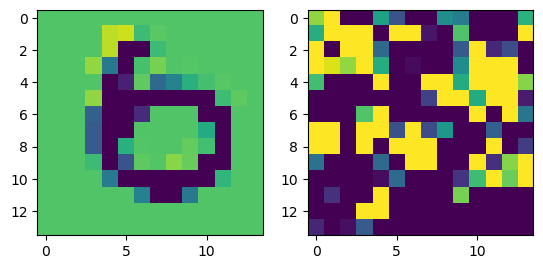

prediction: tensor([4, 9, 8]), tensor([1.4143, 0.7184, 0.3745]) groudtruth: 9
-0.17836124 0.15508251


<Figure size 640x480 with 0 Axes>

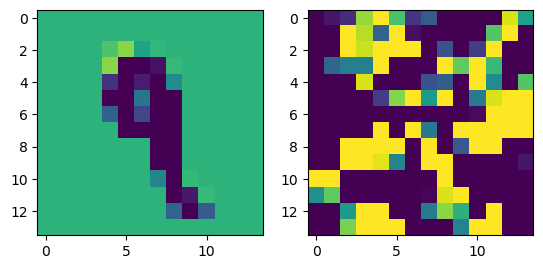

prediction: tensor([4, 8, 5]), tensor([1.4608, 1.3478, 0.8739]) groudtruth: 8
-0.13725954 0.19590579


<Figure size 640x480 with 0 Axes>

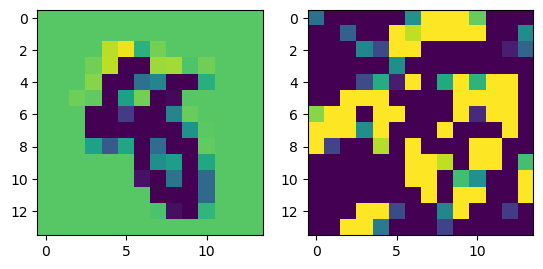

prediction: tensor([1, 9, 7]), tensor([1.4935, 0.9164, 0.8639]) groudtruth: 9
-0.14614499 0.1403893


<Figure size 640x480 with 0 Axes>

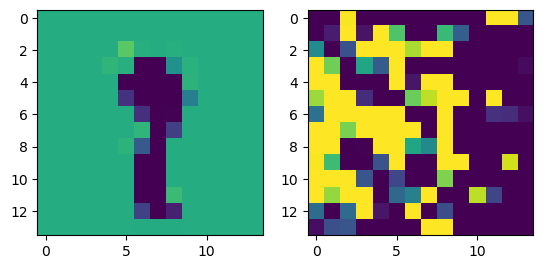

prediction: tensor([7, 2, 8]), tensor([1.5526, 0.9174, 0.5283]) groudtruth: 2
-0.14212763 0.12758745


<Figure size 640x480 with 0 Axes>

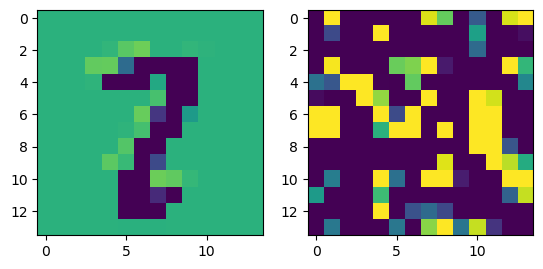

prediction: tensor([0, 5, 3]), tensor([1.4826, 1.2535, 1.0885]) groudtruth: 5
-0.14332521 0.17881158


<Figure size 640x480 with 0 Axes>

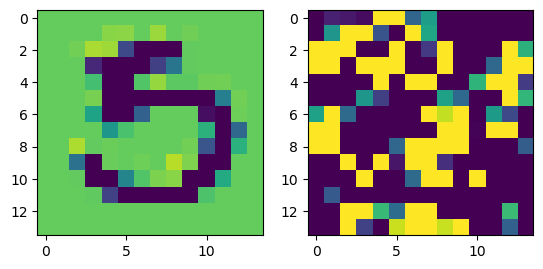

prediction: tensor([7, 2, 0]), tensor([1.5196, 1.4261, 0.6059]) groudtruth: 2
-0.18011922 0.15702619


<Figure size 640x480 with 0 Axes>

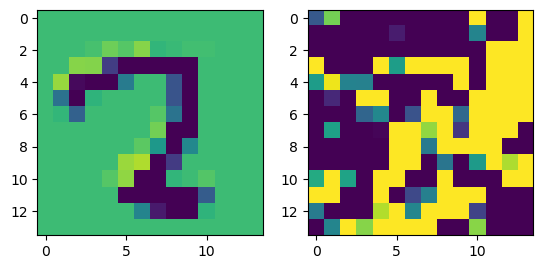

prediction: tensor([8, 5, 9]), tensor([1.1249, 0.7412, 0.6481]) groudtruth: 9
-0.1609909 0.15973881


<Figure size 640x480 with 0 Axes>

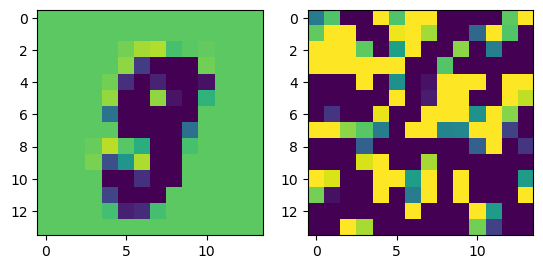

prediction: tensor([5, 3, 8]), tensor([1.8879, 1.2212, 0.3875]) groudtruth: 3
-0.15291208 0.14058629


<Figure size 640x480 with 0 Axes>

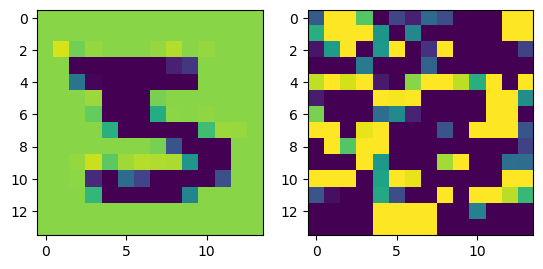

prediction: tensor([2, 9, 3]), tensor([0.8946, 0.7694, 0.6673]) groudtruth: 7
-0.16072881 0.11765717


<Figure size 640x480 with 0 Axes>

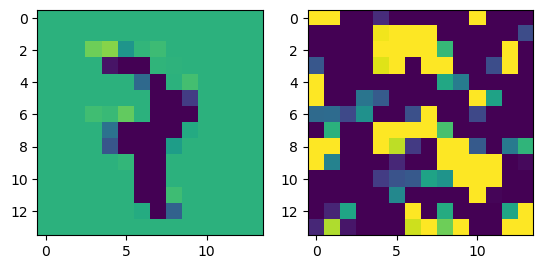

prediction: tensor([2, 8, 3]), tensor([1.5428, 0.7112, 0.5481]) groudtruth: 8
-0.12677282 0.17106225


<Figure size 640x480 with 0 Axes>

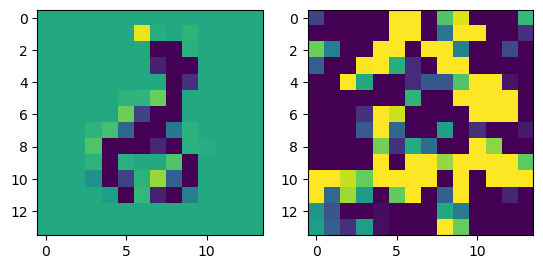

prediction: tensor([8, 2, 3]), tensor([1.5009, 1.2952, 0.7552]) groudtruth: 2
-0.11394769 0.1348453


<Figure size 640x480 with 0 Axes>

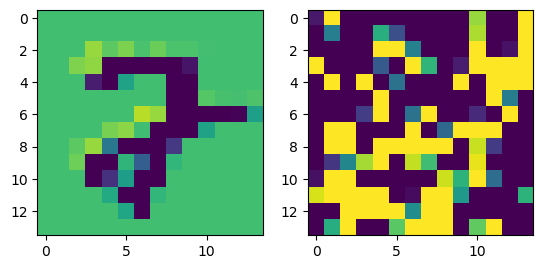

prediction: tensor([3, 2, 8]), tensor([1.1788, 1.0350, 0.9256]) groudtruth: 8
-0.09901005 0.096439704


<Figure size 640x480 with 0 Axes>

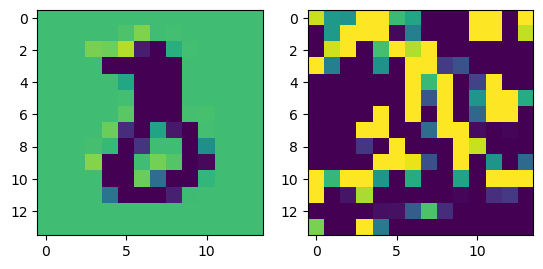

prediction: tensor([8, 2, 1]), tensor([1.1738, 1.0238, 0.6881]) groudtruth: 2
-0.14805222 0.1362924


<Figure size 640x480 with 0 Axes>

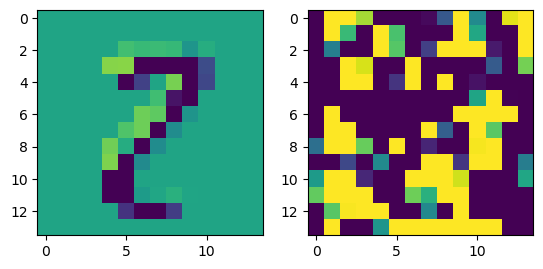

prediction: tensor([8, 1, 6]), tensor([1.1937, 0.7864, 0.3018]) groudtruth: 1
-0.10481727 0.12815395


<Figure size 640x480 with 0 Axes>

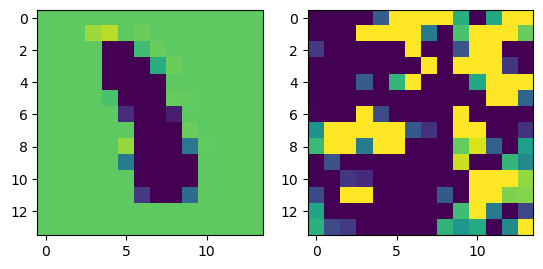

prediction: tensor([3, 5, 6]), tensor([2.3297, 1.5305, 0.0317]) groudtruth: 5
-0.11589527 0.16129458


<Figure size 640x480 with 0 Axes>

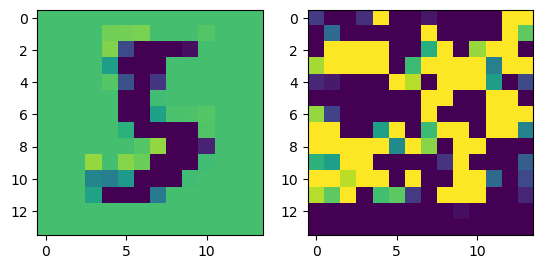

prediction: tensor([3, 9, 2]), tensor([1.3196, 1.0165, 0.4030]) groudtruth: 7
-0.11437476 0.15732074


<Figure size 640x480 with 0 Axes>

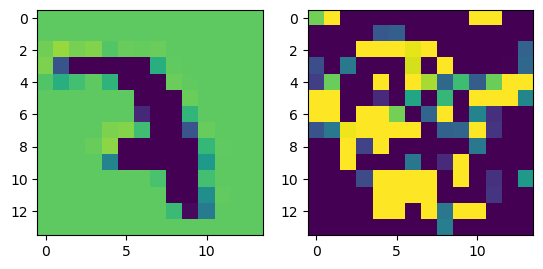

prediction: tensor([6, 5, 2]), tensor([0.9391, 0.8359, 0.0467]) groudtruth: 0
-0.1201123 0.10298677


<Figure size 640x480 with 0 Axes>

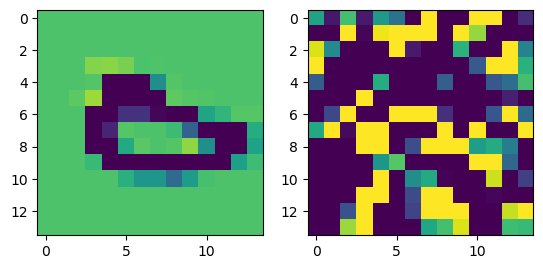

prediction: tensor([9, 4, 7]), tensor([2.0375, 0.7320, 0.3262]) groudtruth: 4
-0.10153568 0.14098324


<Figure size 640x480 with 0 Axes>

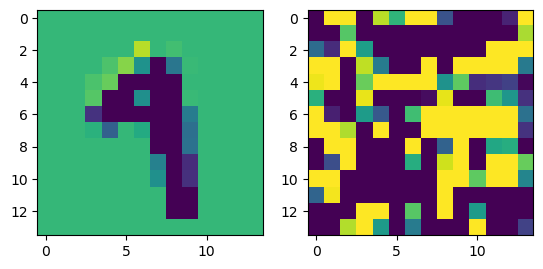

prediction: tensor([8, 2, 0]), tensor([1.7503, 1.2560, 0.4470]) groudtruth: 2
-0.16854614 0.14861318


<Figure size 640x480 with 0 Axes>

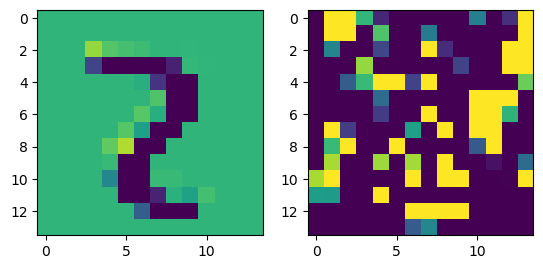

prediction: tensor([3, 8, 0]), tensor([1.7027, 0.9672, 0.6248]) groudtruth: 8
-0.13661063 0.12946874


<Figure size 640x480 with 0 Axes>

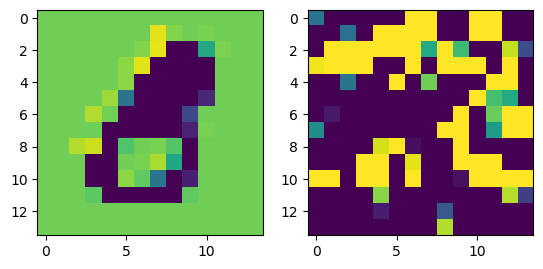

prediction: tensor([9, 7, 0]), tensor([2.1054, 1.6498, 1.4072]) groudtruth: 7
-0.13336104 0.13330463


<Figure size 640x480 with 0 Axes>

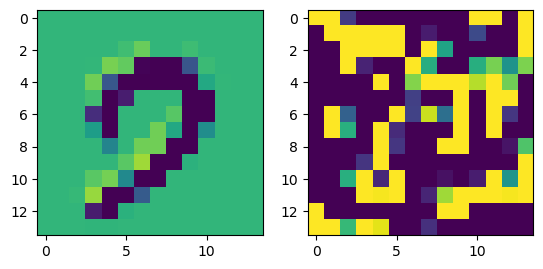

prediction: tensor([2, 8, 6]), tensor([1.2414, 1.1486, 0.6550]) groudtruth: 8
-0.11548555 0.13942984


<Figure size 640x480 with 0 Axes>

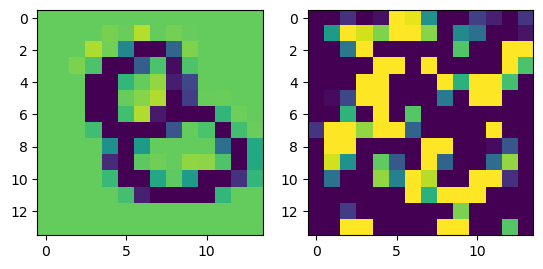

prediction: tensor([3, 2, 7]), tensor([0.8923, 0.5756, 0.4045]) groudtruth: 7
-0.10970819 0.1435939


<Figure size 640x480 with 0 Axes>

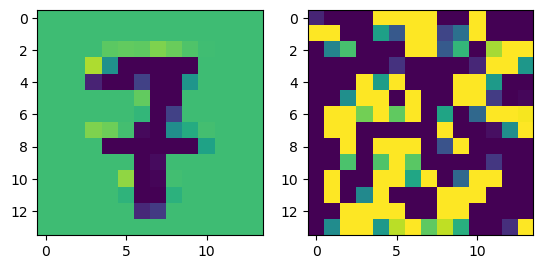

prediction: tensor([1, 9, 7]), tensor([0.8093, 0.7605, 0.5927]) groudtruth: 7
-0.140903 0.17144403


<Figure size 640x480 with 0 Axes>

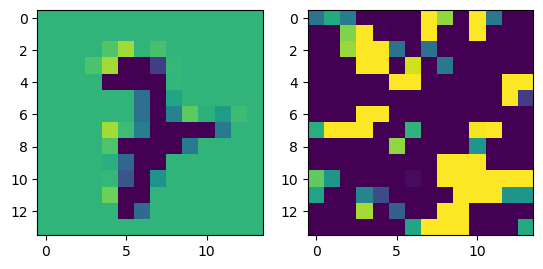

prediction: tensor([5, 3, 8]), tensor([2.5393, 1.8328, 0.7291]) groudtruth: 3
-0.19370526 0.12051626


<Figure size 640x480 with 0 Axes>

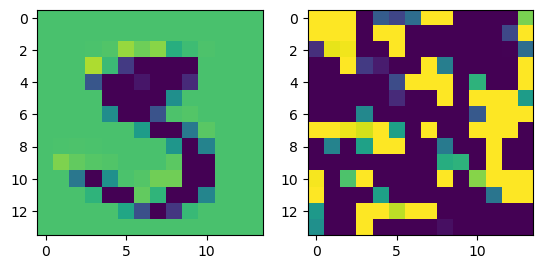

prediction: tensor([0, 8, 2]), tensor([1.9274, 0.8721, 0.7121]) groudtruth: 2
-0.18659586 0.10370814


<Figure size 640x480 with 0 Axes>

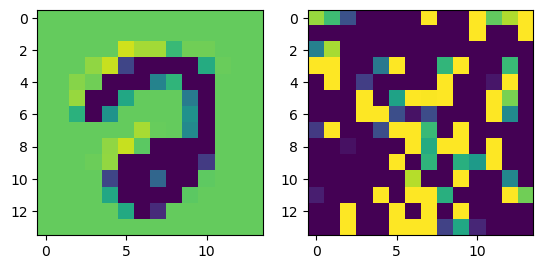

prediction: tensor([0, 6, 8]), tensor([2.8864, 1.4037, 0.1203]) groudtruth: 6
-0.16136307 0.11558922


<Figure size 640x480 with 0 Axes>

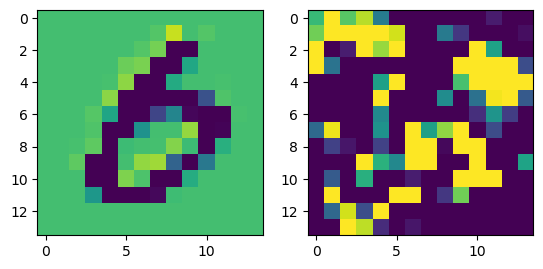

prediction: tensor([8, 7, 2]), tensor([0.9479, 0.8371, 0.2442]) groudtruth: 7
-0.091827095 0.10046007


<Figure size 640x480 with 0 Axes>

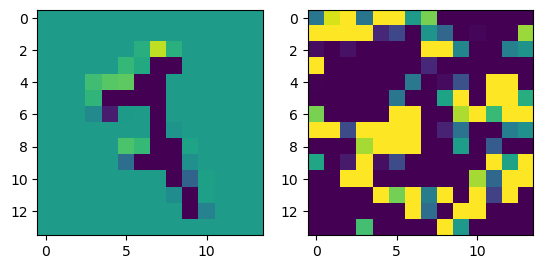

prediction: tensor([7, 9, 3]), tensor([1.1089, 0.9542, 0.8756]) groudtruth: 3
-0.12578595 0.15959196


<Figure size 640x480 with 0 Axes>

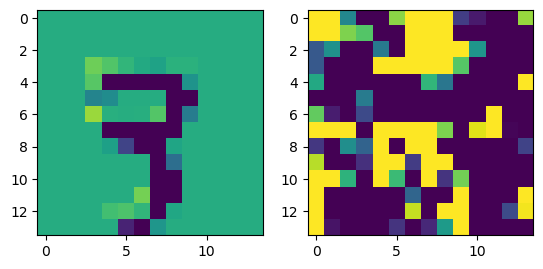

prediction: tensor([4, 8, 5]), tensor([2.0066, 1.3558, 0.2081]) groudtruth: 8
-0.12397021 0.18068084


<Figure size 640x480 with 0 Axes>

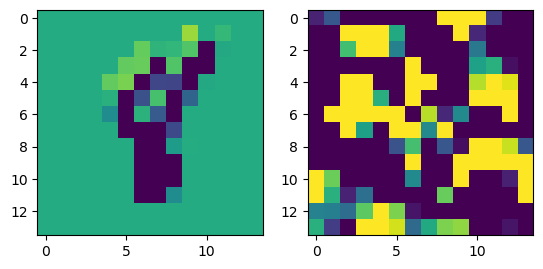

prediction: tensor([5, 6, 8]), tensor([1.3088, 1.0130, 0.9743]) groudtruth: 6
-0.17263061 0.14394815


<Figure size 640x480 with 0 Axes>

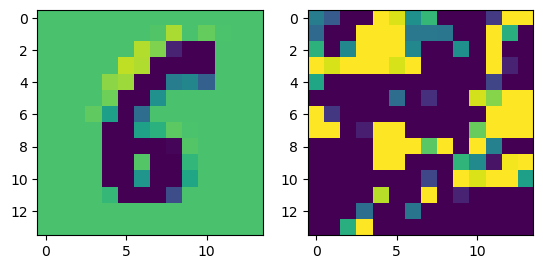

prediction: tensor([7, 9, 4]), tensor([0.7615, 0.6789, 0.6448]) groudtruth: 9
-0.16600776 0.11626846


<Figure size 640x480 with 0 Axes>

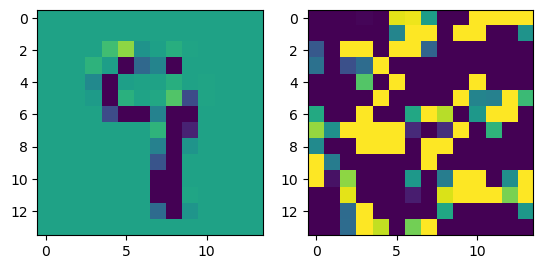

prediction: tensor([2, 3, 7]), tensor([1.7296, 1.4687, 0.7614]) groudtruth: 7
-0.15756619 0.15291895


<Figure size 640x480 with 0 Axes>

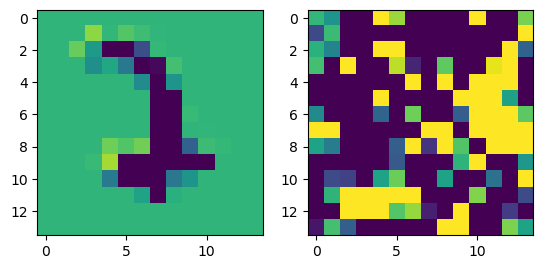

prediction: tensor([1, 7, 2]), tensor([1.9159, 1.0369, 0.2596]) groudtruth: 7
-0.15007657 0.18563616


<Figure size 640x480 with 0 Axes>

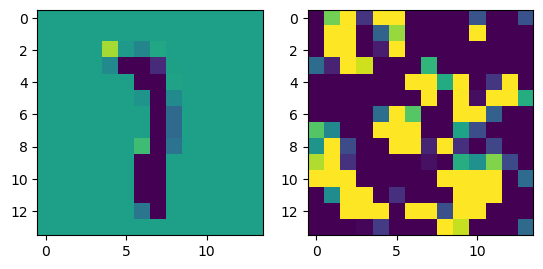

prediction: tensor([2, 7, 4]), tensor([2.4045, 0.9715, 0.3276]) groudtruth: 7
-0.14580196 0.22497849


<Figure size 640x480 with 0 Axes>

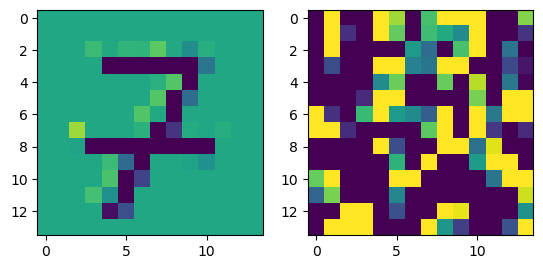

prediction: tensor([9, 5, 6]), tensor([0.7116, 0.6557, 0.3875]) groudtruth: 5
-0.16664779 0.18895566


<Figure size 640x480 with 0 Axes>

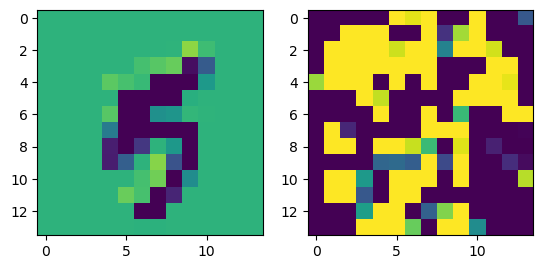

prediction: tensor([0, 8, 3]), tensor([1.2909, 0.8504, 0.4814]) groudtruth: 8
-0.16299099 0.1518977


<Figure size 640x480 with 0 Axes>

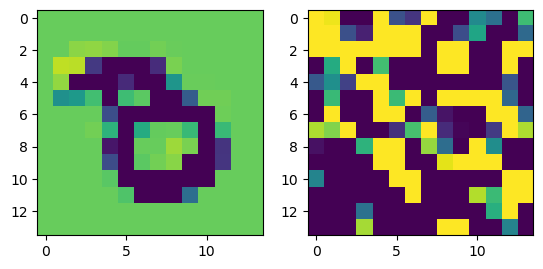

prediction: tensor([1, 7, 2]), tensor([1.3924, 0.7223, 0.6424]) groudtruth: 7
-0.1266433 0.15022261


<Figure size 640x480 with 0 Axes>

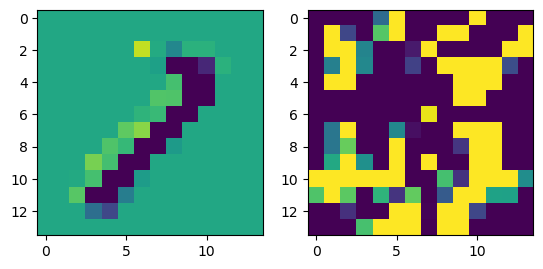

prediction: tensor([8, 2, 4]), tensor([1.3929, 1.3908, 0.4920]) groudtruth: 2
-0.11637914 0.16265938


<Figure size 640x480 with 0 Axes>

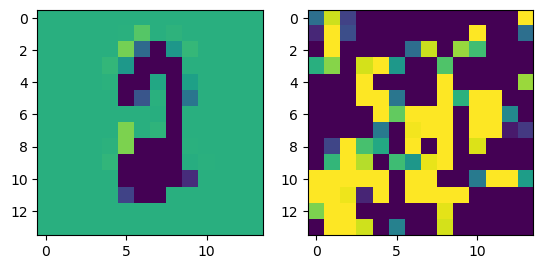

prediction: tensor([9, 4, 6]), tensor([0.9586, 0.7825, 0.2724]) groudtruth: 4
-0.16642845 0.14598599


<Figure size 640x480 with 0 Axes>

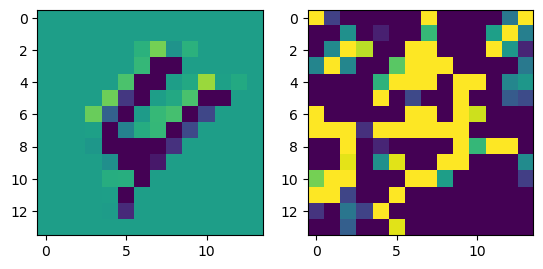

prediction: tensor([9, 4, 6]), tensor([1.8399, 1.7460, 0.2995]) groudtruth: 4
-0.10823244 0.14875157


<Figure size 640x480 with 0 Axes>

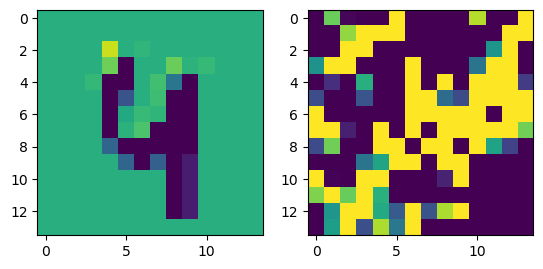

prediction: tensor([6, 4, 2]), tensor([2.1819, 1.0615, 0.0367]) groudtruth: 4
-0.13522965 0.16143972


<Figure size 640x480 with 0 Axes>

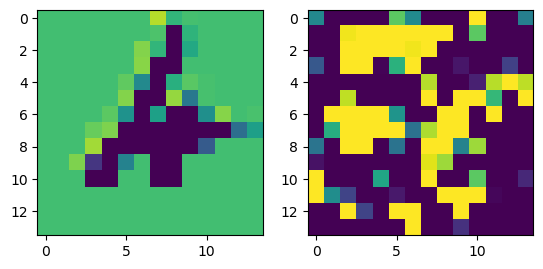

prediction: tensor([8, 6, 0]), tensor([1.6155, 1.5916, 0.7240]) groudtruth: 6
-0.1489451 0.15129855


<Figure size 640x480 with 0 Axes>

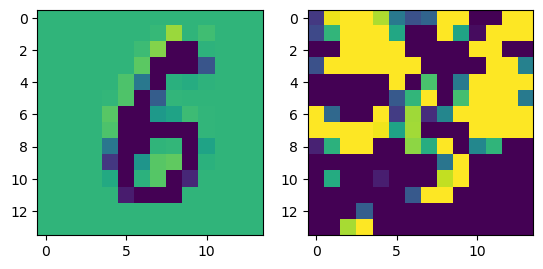

prediction: tensor([2, 7, 9]), tensor([1.6594, 1.1554, 1.0767]) groudtruth: 7
-0.17638713 0.1492416


<Figure size 640x480 with 0 Axes>

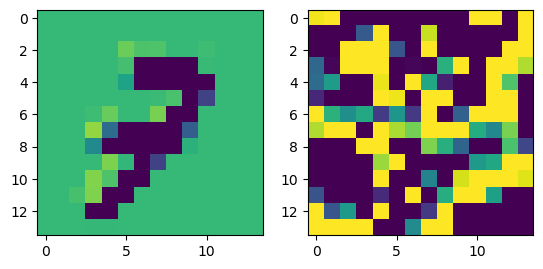

prediction: tensor([0, 3, 2]), tensor([0.8476, 0.8184, 0.7882]) groudtruth: 2
-0.12300992 0.15470558


<Figure size 640x480 with 0 Axes>

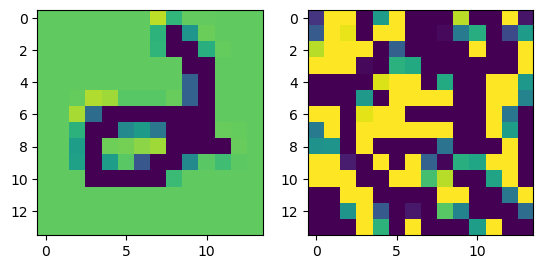

prediction: tensor([5, 3, 4]), tensor([1.5881, 1.1197, 0.7197]) groudtruth: 9
-0.15061474 0.09736292


<Figure size 640x480 with 0 Axes>

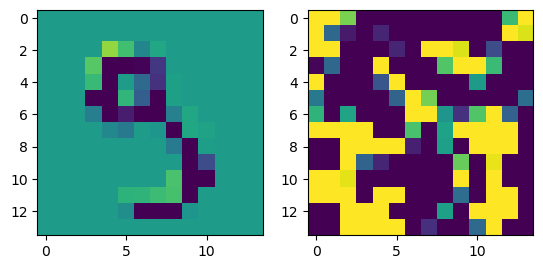

prediction: tensor([2, 5, 6]), tensor([1.3903, 0.8328, 0.6916]) groudtruth: 5
-0.13800025 0.1257265


<Figure size 640x480 with 0 Axes>

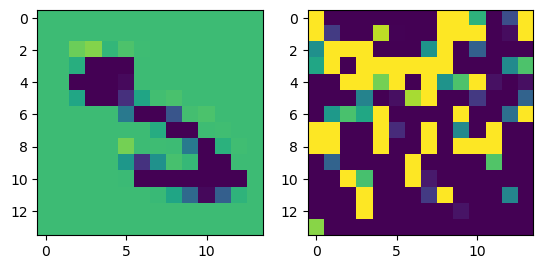

prediction: tensor([4, 1, 8]), tensor([1.4711, 1.3715, 0.7078]) groudtruth: 1
-0.159082 0.15146154


<Figure size 640x480 with 0 Axes>

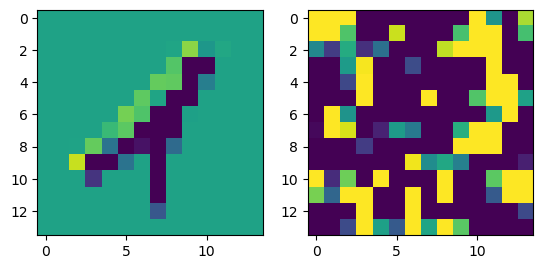

prediction: tensor([4, 5, 8]), tensor([1.4040, 0.7723, 0.5316]) groudtruth: 9
-0.13040012 0.14102967


<Figure size 640x480 with 0 Axes>

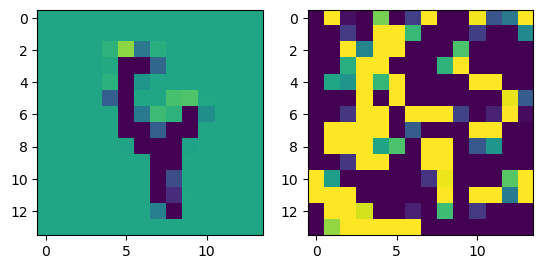

prediction: tensor([3, 8, 5]), tensor([0.9038, 0.7332, 0.5869]) groudtruth: 9
-0.18923187 0.1648288


<Figure size 640x480 with 0 Axes>

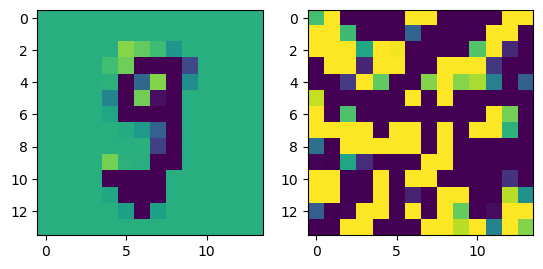

prediction: tensor([2, 8, 6]), tensor([1.5721, 1.3475, 0.4323]) groudtruth: 8
-0.15991366 0.13949174


<Figure size 640x480 with 0 Axes>

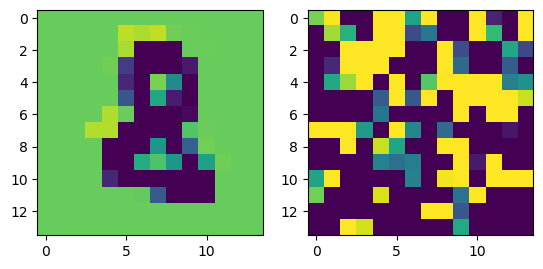

prediction: tensor([9, 2, 0]), tensor([1.3567, 0.7139, 0.4851]) groudtruth: 4
-0.110174775 0.13375187


<Figure size 640x480 with 0 Axes>

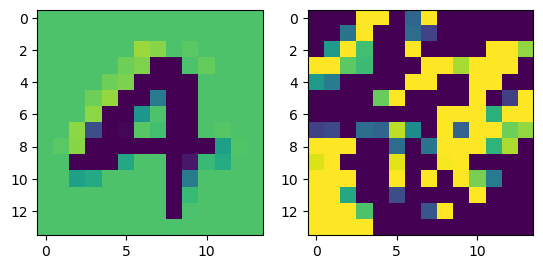

prediction: tensor([0, 2, 6]), tensor([2.0331, 1.6667, 0.4760]) groudtruth: 2
-0.16493839 0.14867221


<Figure size 640x480 with 0 Axes>

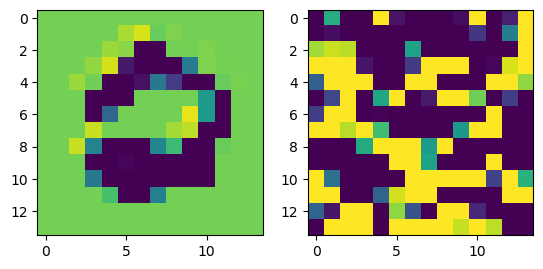

prediction: tensor([2, 7, 3]), tensor([1.5269, 0.6202, 0.5327]) groudtruth: 7
-0.15764791 0.13836682


<Figure size 640x480 with 0 Axes>

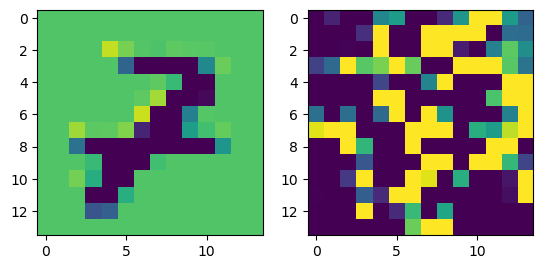

prediction: tensor([9, 7, 4]), tensor([2.1713, 0.3774, 0.2597]) groudtruth: 4
-0.1248492 0.13293608


<Figure size 640x480 with 0 Axes>

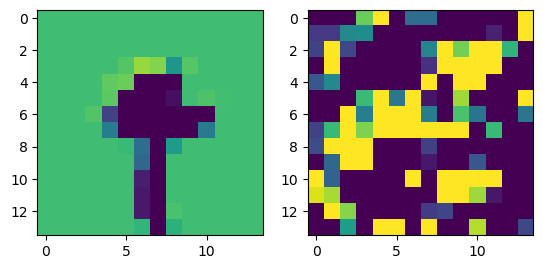

prediction: tensor([0, 7, 9]), tensor([ 2.3565,  2.1014, -0.0072]) groudtruth: 7
-0.15633011 0.17210315


<Figure size 640x480 with 0 Axes>

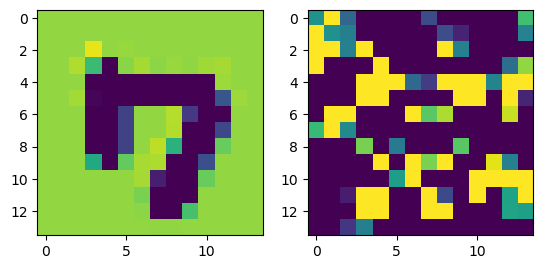

prediction: tensor([0, 4, 6]), tensor([2.5137, 1.0376, 0.8549]) groudtruth: 6
-0.122612655 0.15631337


<Figure size 640x480 with 0 Axes>

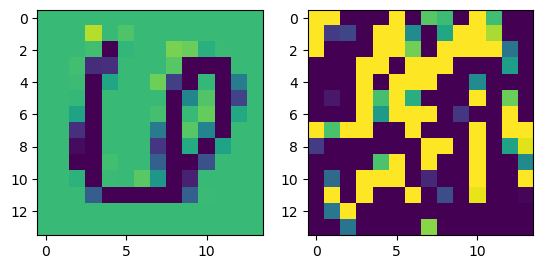

prediction: tensor([9, 4, 3]), tensor([ 2.1047,  1.5388, -0.1016]) groudtruth: 4
-0.10952115 0.11020807


<Figure size 640x480 with 0 Axes>

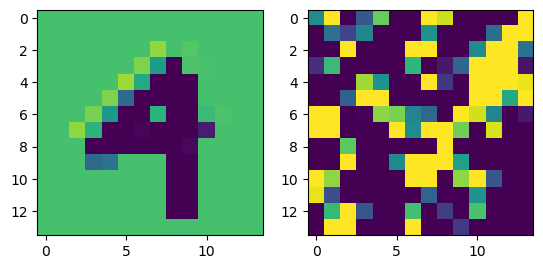

prediction: tensor([2, 3, 8]), tensor([1.4227, 0.8845, 0.5496]) groudtruth: 1
-0.14963895 0.11438768


<Figure size 640x480 with 0 Axes>

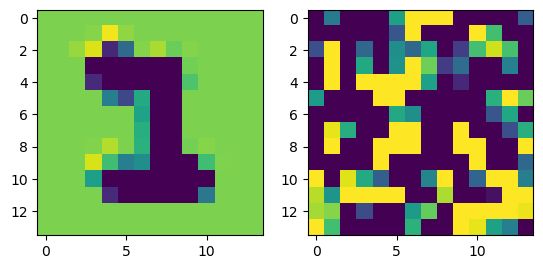

prediction: tensor([8, 0, 7]), tensor([2.0579, 1.1721, 0.2092]) groudtruth: 0
-0.13614786 0.16816893


<Figure size 640x480 with 0 Axes>

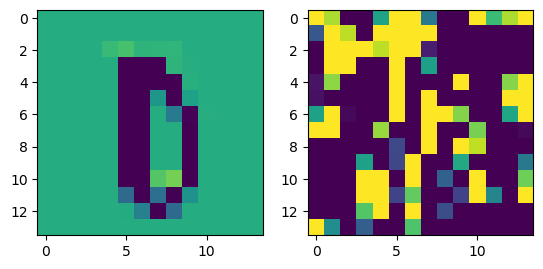

prediction: tensor([0, 2, 3]), tensor([1.7156, 1.2967, 1.0106]) groudtruth: 2
-0.18434697 0.11896813


<Figure size 640x480 with 0 Axes>

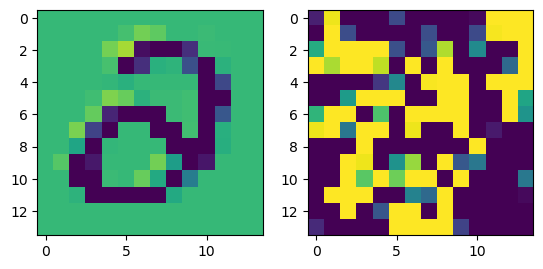

prediction: tensor([1, 7, 9]), tensor([1.6507, 0.8522, 0.4064]) groudtruth: 9
-0.12745076 0.21955267


<Figure size 640x480 with 0 Axes>

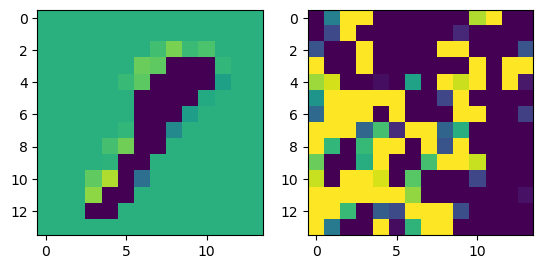

prediction: tensor([0, 8, 6]), tensor([1.9944, 1.1941, 0.1973]) groudtruth: 8
-0.11996156 0.14160341


<Figure size 640x480 with 0 Axes>

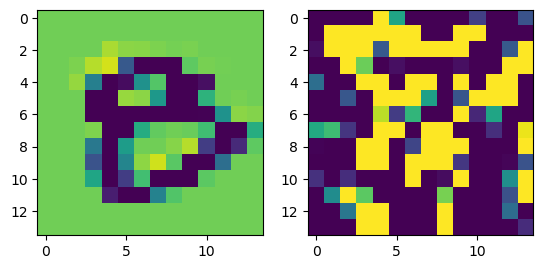

prediction: tensor([6, 4, 9]), tensor([0.6142, 0.5958, 0.5741]) groudtruth: 5
-0.1417622 0.16007242


<Figure size 640x480 with 0 Axes>

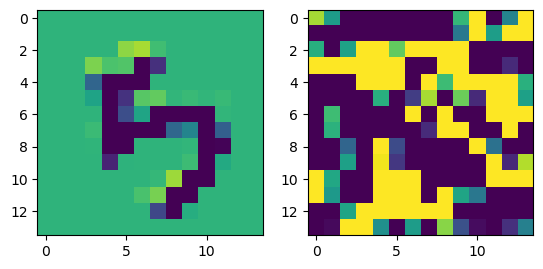

prediction: tensor([0, 9, 6]), tensor([1.5239, 0.6042, 0.1392]) groudtruth: 9
-0.14662302 0.17528462


<Figure size 640x480 with 0 Axes>

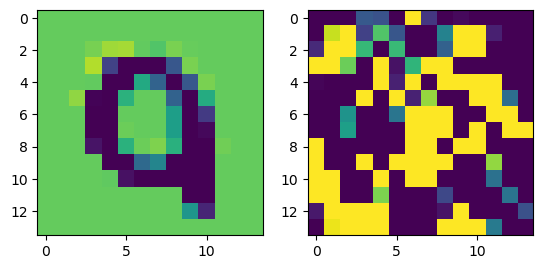

prediction: tensor([1, 4, 9]), tensor([1.1548, 0.7351, 0.2573]) groudtruth: 9
-0.15438008 0.15869397


<Figure size 640x480 with 0 Axes>

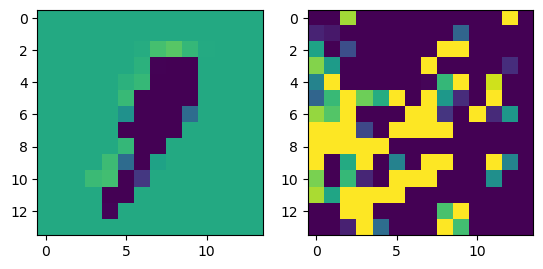

prediction: tensor([4, 8, 9]), tensor([1.2533, 0.5184, 0.3279]) groudtruth: 9
-0.14345199 0.13611375


<Figure size 640x480 with 0 Axes>

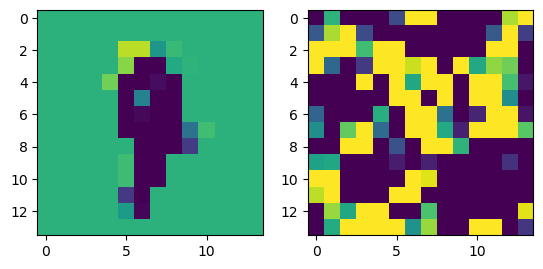

prediction: tensor([5, 3, 8]), tensor([1.8069, 1.5582, 0.4943]) groudtruth: 3
-0.14223891 0.12829658


<Figure size 640x480 with 0 Axes>

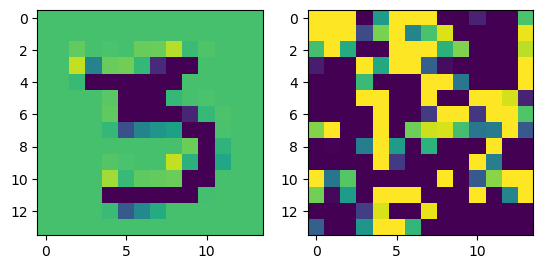

prediction: tensor([8, 4, 1]), tensor([1.1158, 0.2836, 0.2218]) groudtruth: 7
-0.12605649 0.119713254


<Figure size 640x480 with 0 Axes>

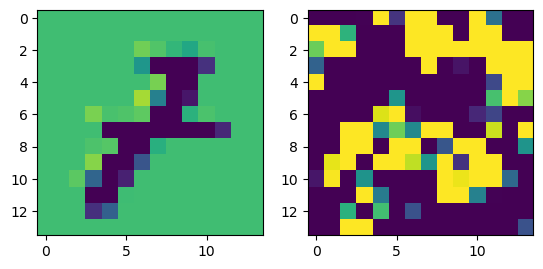

prediction: tensor([9, 4, 1]), tensor([2.0216, 1.9968, 0.4933]) groudtruth: 4
-0.1611222 0.13661562


<Figure size 640x480 with 0 Axes>

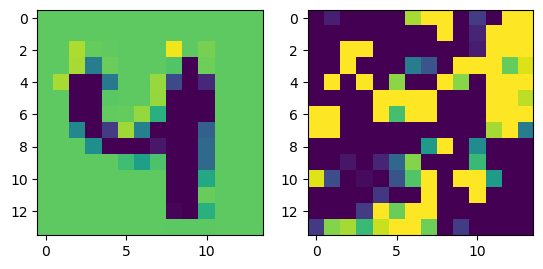

prediction: tensor([6, 0, 7]), tensor([ 2.1402e+00,  1.8758e+00, -9.1980e-04]) groudtruth: 0
-0.14741385 0.13520575


<Figure size 640x480 with 0 Axes>

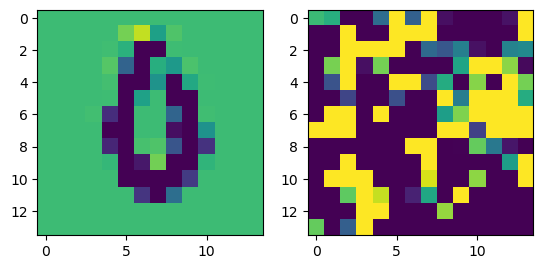

prediction: tensor([8, 5, 7]), tensor([1.8201, 1.2712, 0.4684]) groudtruth: 5
-0.13796914 0.18324922


<Figure size 640x480 with 0 Axes>

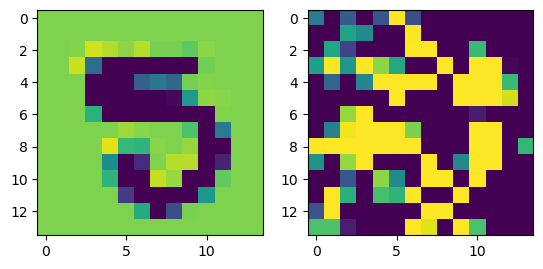

prediction: tensor([4, 8, 2]), tensor([1.8869, 0.7013, 0.6899]) groudtruth: 7
-0.17366952 0.12957056


<Figure size 640x480 with 0 Axes>

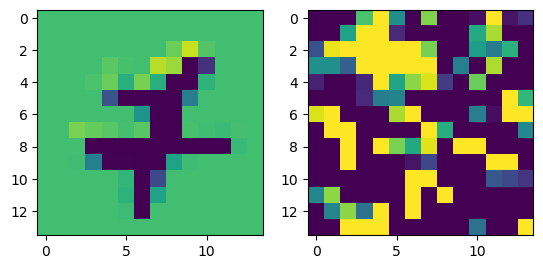

prediction: tensor([0, 8, 3]), tensor([1.3857, 1.2414, 0.5481]) groudtruth: 8
-0.11280537 0.18274343


<Figure size 640x480 with 0 Axes>

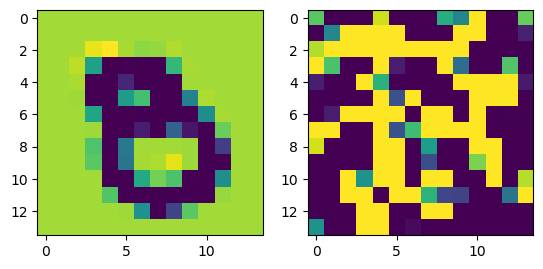

prediction: tensor([4, 9, 5]), tensor([1.2738, 1.0823, 0.7583]) groudtruth: 9
-0.12190044 0.15127492


<Figure size 640x480 with 0 Axes>

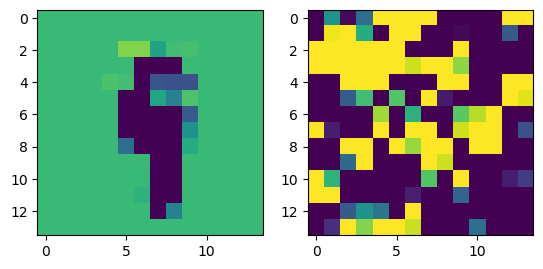

prediction: tensor([2, 0, 3]), tensor([1.3291, 1.0803, 0.9769]) groudtruth: 3
-0.18000162 0.18942672


<Figure size 640x480 with 0 Axes>

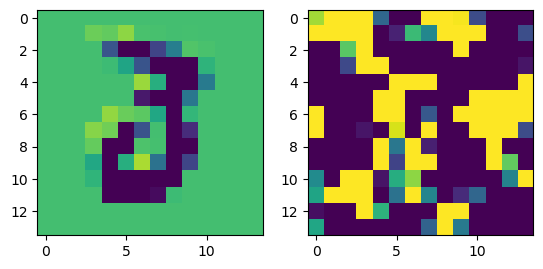

prediction: tensor([2, 7, 3]), tensor([1.4919, 1.4273, 1.0658]) groudtruth: 3
-0.119098306 0.1225465


<Figure size 640x480 with 0 Axes>

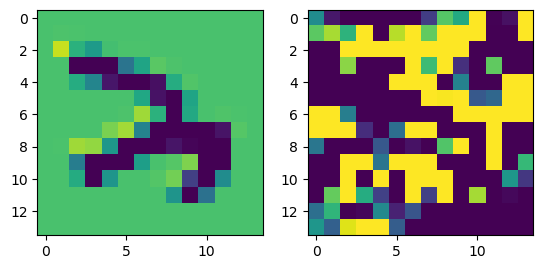

prediction: tensor([5, 3, 8]), tensor([2.0987, 1.8886, 0.3397]) groudtruth: 3
-0.13917953 0.13329469


<Figure size 640x480 with 0 Axes>

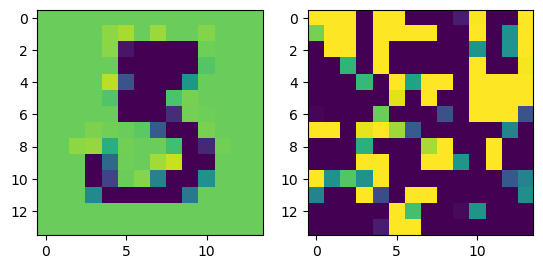

prediction: tensor([5, 3, 8]), tensor([2.0896, 1.1340, 0.4797]) groudtruth: 3
-0.11376166 0.15831116


<Figure size 640x480 with 0 Axes>

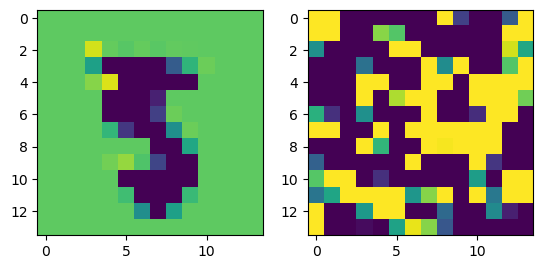

prediction: tensor([2, 3, 7]), tensor([2.2132, 1.1734, 0.7872]) groudtruth: 1
-0.14886421 0.15142523


<Figure size 640x480 with 0 Axes>

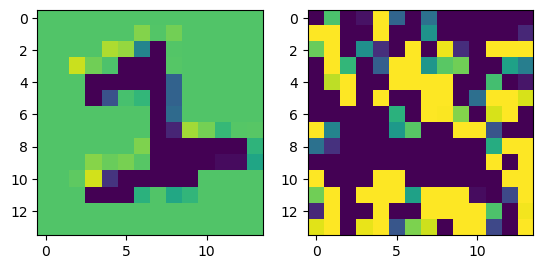

prediction: tensor([6, 4, 2]), tensor([1.2697, 1.0395, 0.4238]) groudtruth: 4
-0.17110229 0.15665463


<Figure size 640x480 with 0 Axes>

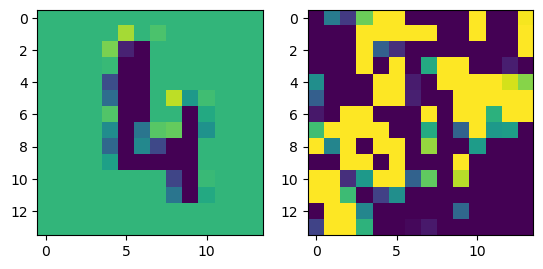

prediction: tensor([3, 2, 8]), tensor([1.8989, 0.8353, 0.5751]) groudtruth: 8
-0.15491807 0.1198041


<Figure size 640x480 with 0 Axes>

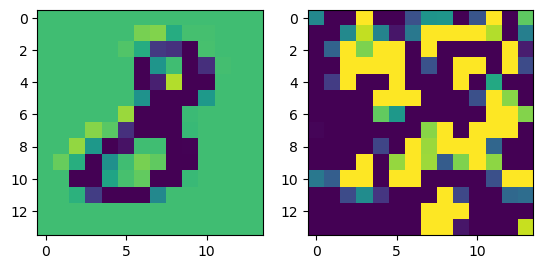

prediction: tensor([5, 4, 3]), tensor([1.0474, 0.9252, 0.8239]) groudtruth: 9
-0.13372022 0.16052078


<Figure size 640x480 with 0 Axes>

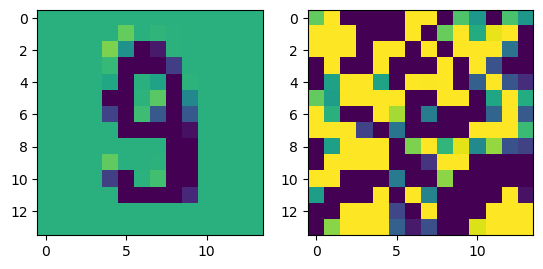

prediction: tensor([0, 6, 8]), tensor([2.4641, 2.0657, 0.1268]) groudtruth: 6
-0.14867944 0.10872558


<Figure size 640x480 with 0 Axes>

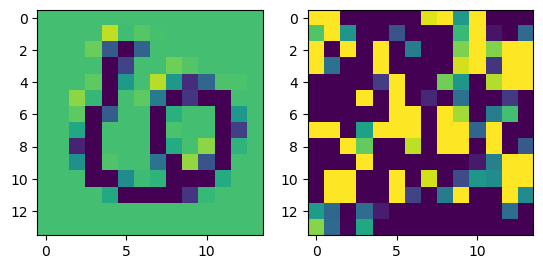

prediction: tensor([3, 7, 2]), tensor([1.3009, 0.9095, 0.7008]) groudtruth: 7
-0.12693566 0.10327634


<Figure size 640x480 with 0 Axes>

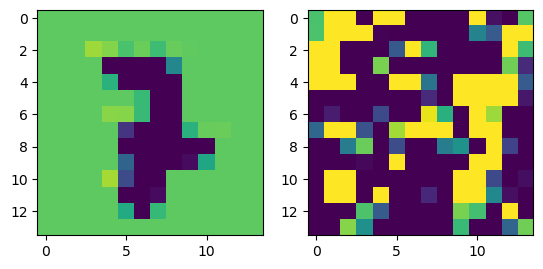

prediction: tensor([9, 7, 4]), tensor([1.7652, 1.1730, 0.5938]) groudtruth: 7
-0.15543383 0.14839396


<Figure size 640x480 with 0 Axes>

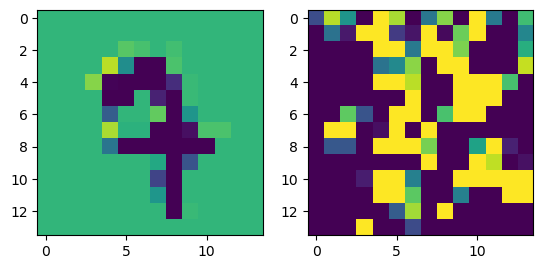

prediction: tensor([7, 5, 9]), tensor([1.5611, 0.9940, 0.6066]) groudtruth: 5
-0.16188139 0.13905935


<Figure size 640x480 with 0 Axes>

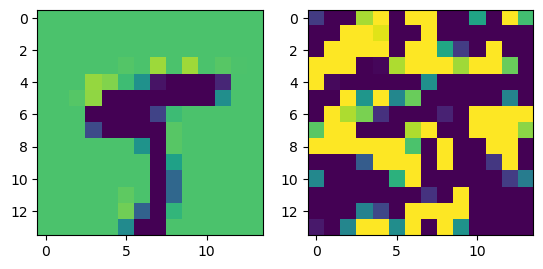

prediction: tensor([7, 9, 1]), tensor([1.7478, 1.1875, 0.4714]) groudtruth: 9
-0.16356319 0.14512935


<Figure size 640x480 with 0 Axes>

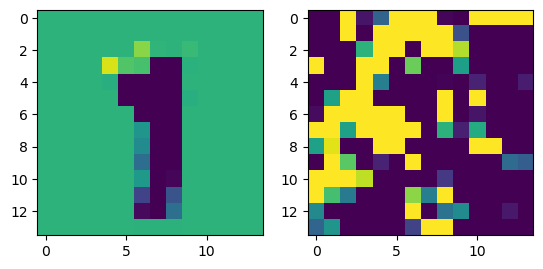

prediction: tensor([1, 8, 4]), tensor([0.7554, 0.6184, 0.5732]) groudtruth: 9
-0.14573443 0.13952723


<Figure size 640x480 with 0 Axes>

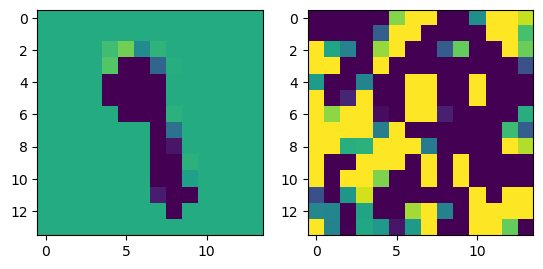

prediction: tensor([4, 6, 9]), tensor([2.2210, 1.1687, 0.7380]) groudtruth: 6
-0.13065165 0.13834724


<Figure size 640x480 with 0 Axes>

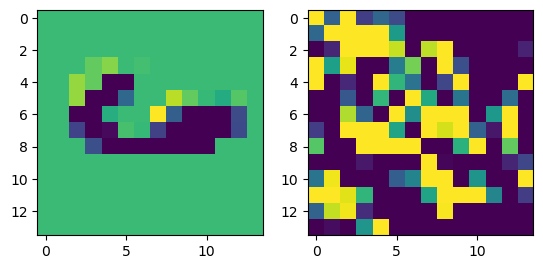

prediction: tensor([0, 5, 6]), tensor([1.2697, 0.8659, 0.4019]) groudtruth: 5
-0.14671612 0.15844792


<Figure size 640x480 with 0 Axes>

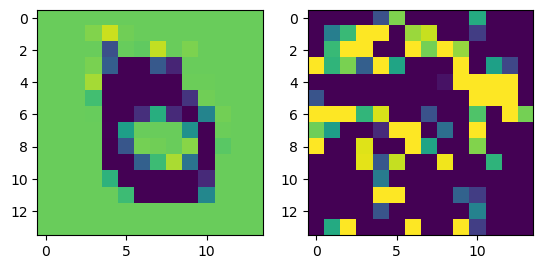

prediction: tensor([3, 8, 5]), tensor([1.0085, 0.9291, 0.5053]) groudtruth: 9
-0.14672452 0.11521389


<Figure size 640x480 with 0 Axes>

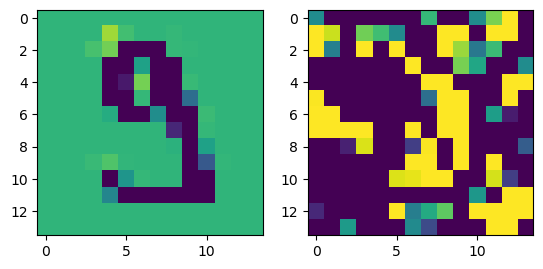

prediction: tensor([4, 1, 8]), tensor([0.8775, 0.7834, 0.4481]) groudtruth: 1
-0.13641685 0.17769766


<Figure size 640x480 with 0 Axes>

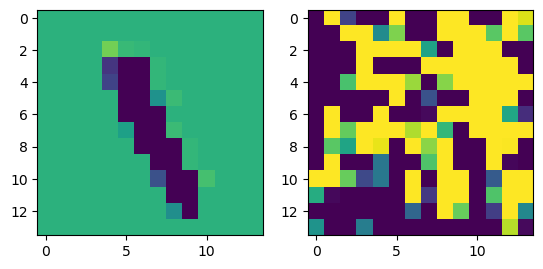

prediction: tensor([3, 4, 8]), tensor([1.0959, 0.9640, 0.7977]) groudtruth: 9
-0.13079411 0.15132965


<Figure size 640x480 with 0 Axes>

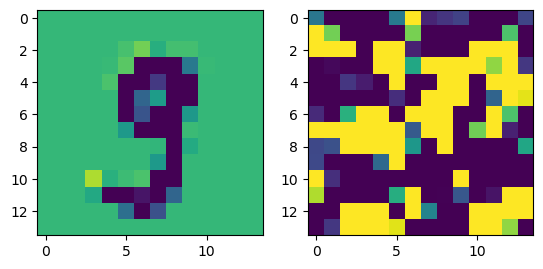

prediction: tensor([9, 4, 3]), tensor([2.5201, 0.6857, 0.2194]) groudtruth: 4
-0.11126661 0.17703085


<Figure size 640x480 with 0 Axes>

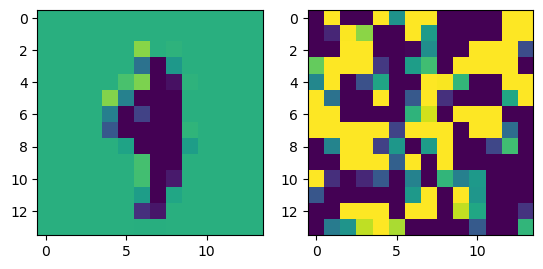

prediction: tensor([5, 8, 3]), tensor([0.8702, 0.8687, 0.5772]) groudtruth: 8
-0.1763683 0.15001798


<Figure size 640x480 with 0 Axes>

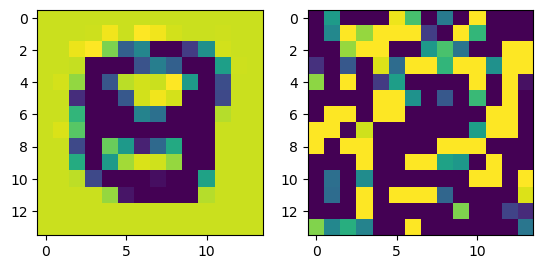

prediction: tensor([2, 7, 8]), tensor([1.4344, 1.2552, 0.6098]) groudtruth: 7
-0.112128735 0.17225981


<Figure size 640x480 with 0 Axes>

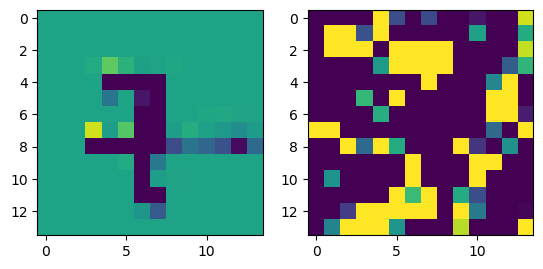

prediction: tensor([8, 5, 2]), tensor([2.5140, 2.1995, 0.2104]) groudtruth: 5
-0.1552642 0.2028803


<Figure size 640x480 with 0 Axes>

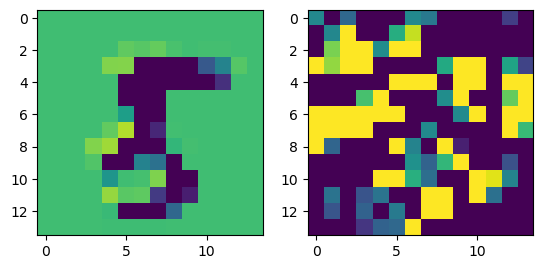

prediction: tensor([6, 2, 5]), tensor([0.8286, 0.8005, 0.6943]) groudtruth: 5
-0.14656657 0.17381409


<Figure size 640x480 with 0 Axes>

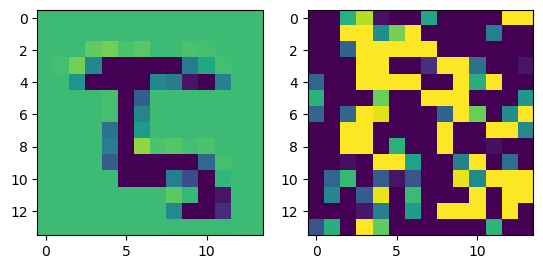

prediction: tensor([6, 2, 0]), tensor([1.7899, 0.8583, 0.4331]) groudtruth: 4
-0.16215533 0.17723107


<Figure size 640x480 with 0 Axes>

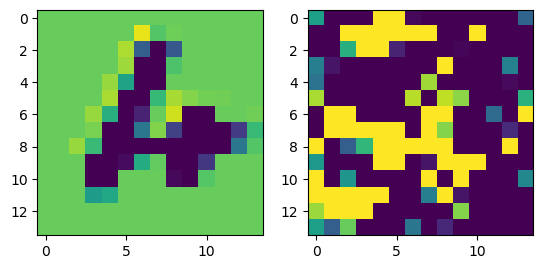

prediction: tensor([4, 9, 6]), tensor([1.5803, 1.4699, 0.7318]) groudtruth: 9
-0.14445263 0.12193076


<Figure size 640x480 with 0 Axes>

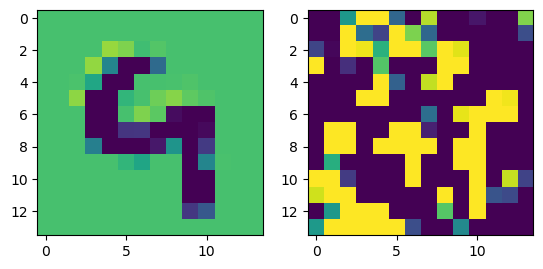

prediction: tensor([0, 6, 4]), tensor([2.0614, 1.5182, 0.5930]) groudtruth: 6
-0.11928475 0.14250627


<Figure size 640x480 with 0 Axes>

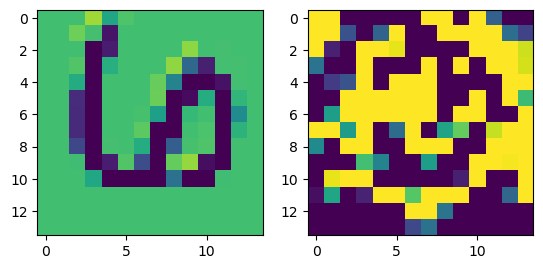

prediction: tensor([3, 2, 7]), tensor([1.5389, 1.0600, 0.4566]) groudtruth: 7
-0.12561262 0.09644698


<Figure size 640x480 with 0 Axes>

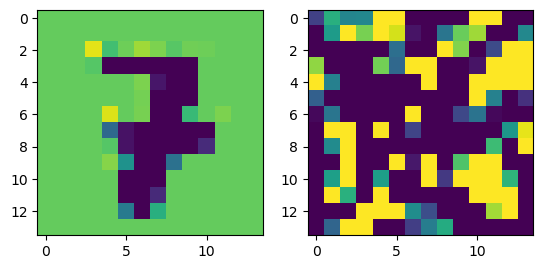

prediction: tensor([4, 9, 8]), tensor([2.1212, 1.7934, 0.1495]) groudtruth: 9
-0.14370024 0.12571076


<Figure size 640x480 with 0 Axes>

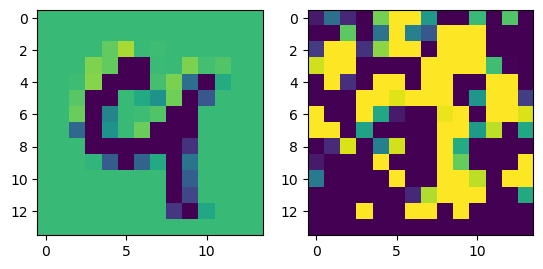

prediction: tensor([8, 0, 5]), tensor([1.4586, 1.2978, 1.1908]) groudtruth: 6
-0.14262831 0.14178184


<Figure size 640x480 with 0 Axes>

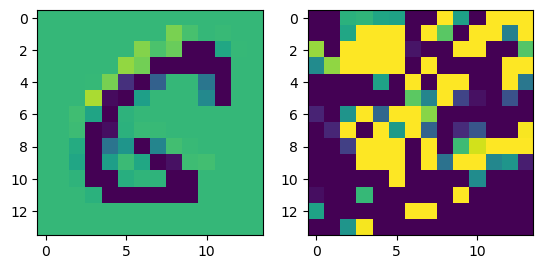

prediction: tensor([8, 0, 5]), tensor([2.0852, 1.3517, 1.3019]) groudtruth: 5
-0.15250796 0.12185496


<Figure size 640x480 with 0 Axes>

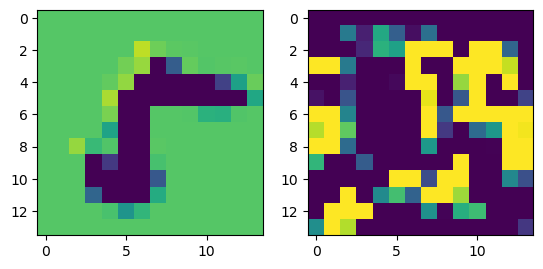

prediction: tensor([2, 3, 7]), tensor([1.8422, 1.7623, 0.7995]) groudtruth: 1
-0.14622885 0.13955656


<Figure size 640x480 with 0 Axes>

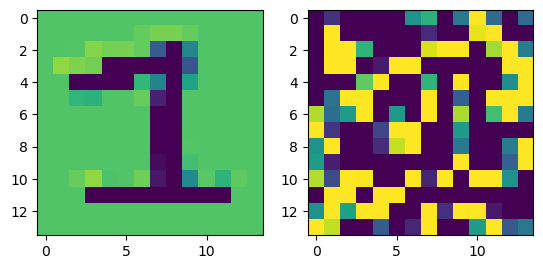

prediction: tensor([6, 4, 2]), tensor([1.7140, 0.5345, 0.4466]) groudtruth: 4
-0.15333039 0.16788112


<Figure size 640x480 with 0 Axes>

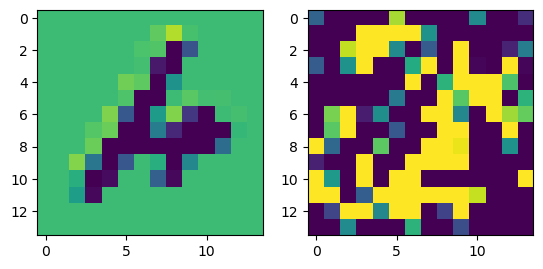

prediction: tensor([1, 7, 3]), tensor([1.8154, 1.4680, 0.2602]) groudtruth: 7
-0.14695883 0.14594088


<Figure size 640x480 with 0 Axes>

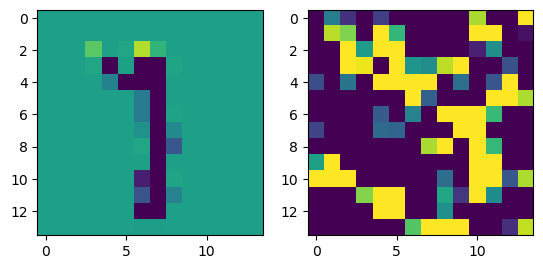

prediction: tensor([3, 2, 5]), tensor([0.9162, 0.9091, 0.6819]) groudtruth: 1
-0.11456025 0.16368484


<Figure size 640x480 with 0 Axes>

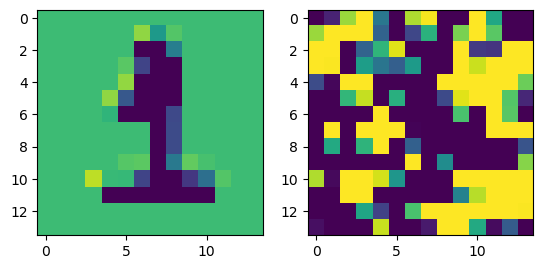

prediction: tensor([0, 8, 5]), tensor([1.3864, 0.9999, 0.5516]) groudtruth: 8
-0.12071222 0.18104732


<Figure size 640x480 with 0 Axes>

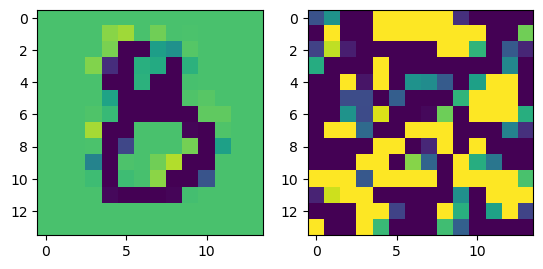

prediction: tensor([3, 2, 9]), tensor([1.4616, 0.9950, 0.2696]) groudtruth: 9
-0.18194455 0.19993989


<Figure size 640x480 with 0 Axes>

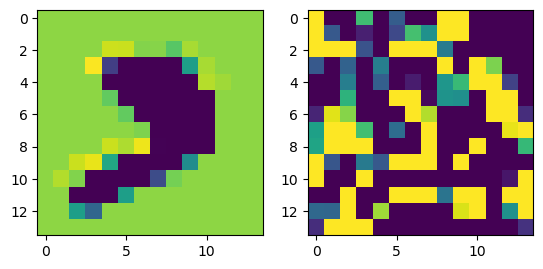

prediction: tensor([2, 8, 9]), tensor([1.5929, 1.2091, 0.0206]) groudtruth: 8
-0.12202352 0.14962748


<Figure size 640x480 with 0 Axes>

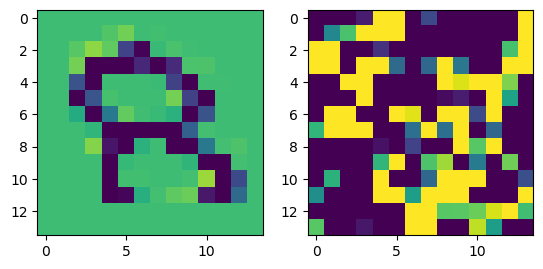

prediction: tensor([9, 4, 7]), tensor([2.0337, 1.1969, 0.9028]) groudtruth: 7
-0.14624703 0.19567265


<Figure size 640x480 with 0 Axes>

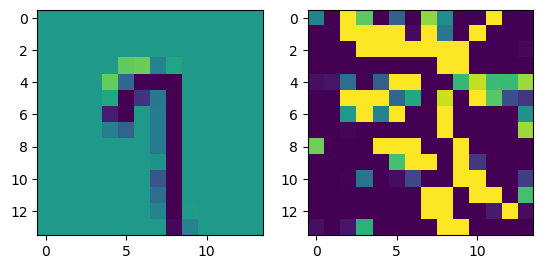

prediction: tensor([1, 0, 6]), tensor([0.9169, 0.8569, 0.7444]) groudtruth: 2
-0.13555062 0.19453743


<Figure size 640x480 with 0 Axes>

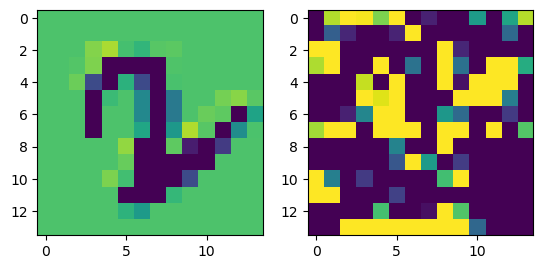

prediction: tensor([7, 9, 3]), tensor([2.7291, 1.5604, 0.0355]) groudtruth: 9
-0.14187288 0.12431879


<Figure size 640x480 with 0 Axes>

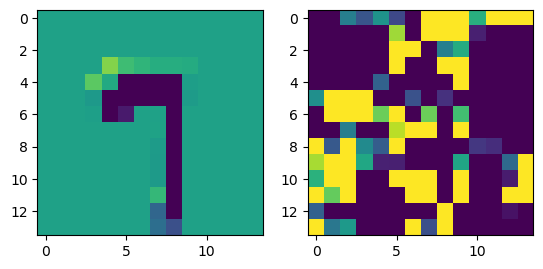

prediction: tensor([2, 7, 3]), tensor([1.8740, 1.6743, 0.5146]) groudtruth: 7
-0.17664778 0.1942806


<Figure size 640x480 with 0 Axes>

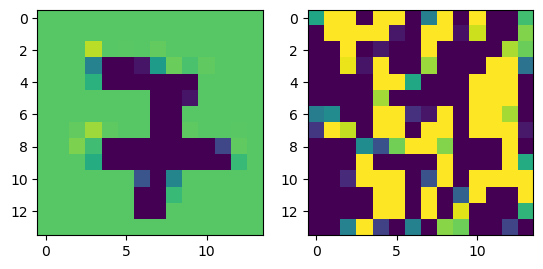

prediction: tensor([3, 9, 2]), tensor([2.2920, 1.6866, 1.0093]) groudtruth: 7
-0.13388342 0.11371955


<Figure size 640x480 with 0 Axes>

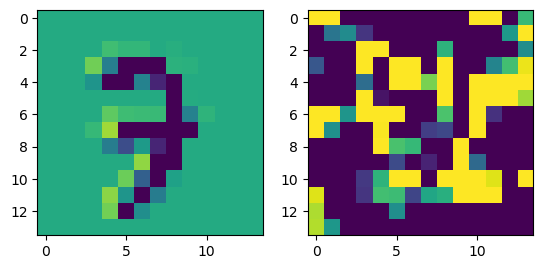

prediction: tensor([5, 6, 8]), tensor([1.2566, 1.1922, 0.8117]) groudtruth: 6
-0.14740372 0.14668776


<Figure size 640x480 with 0 Axes>

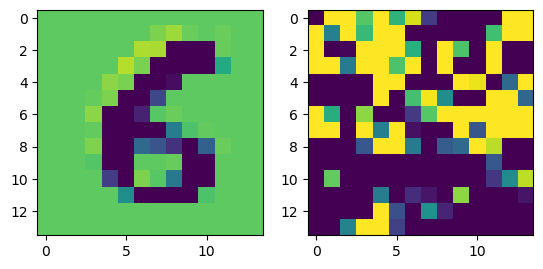

prediction: tensor([3, 5, 8]), tensor([1.9012, 1.6280, 0.4161]) groudtruth: 5
-0.1257093 0.15314463


<Figure size 640x480 with 0 Axes>

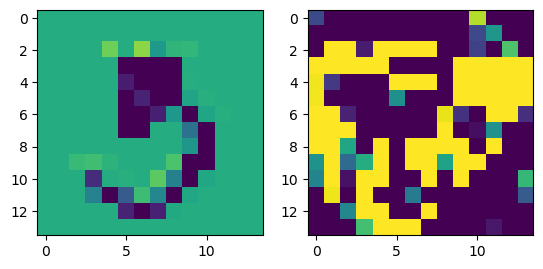

prediction: tensor([7, 8, 2]), tensor([2.0191, 1.3710, 0.7050]) groudtruth: 2
-0.15792483 0.14691323


<Figure size 640x480 with 0 Axes>

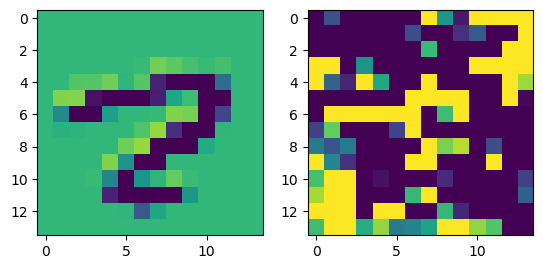

prediction: tensor([8, 9, 3]), tensor([0.8155, 0.7264, 0.5149]) groudtruth: 9
-0.14534694 0.17589071


<Figure size 640x480 with 0 Axes>

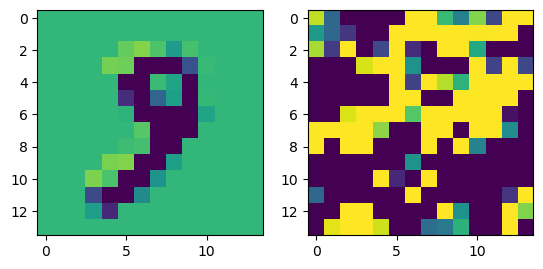

prediction: tensor([0, 2, 1]), tensor([0.7053, 0.5620, 0.5614]) groudtruth: 2
-0.1271931 0.12656817


<Figure size 640x480 with 0 Axes>

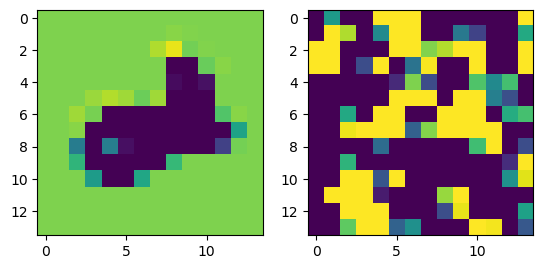

prediction: tensor([8, 6, 0]), tensor([1.2147, 0.9886, 0.8803]) groudtruth: 6
-0.1584577 0.12429682


<Figure size 640x480 with 0 Axes>

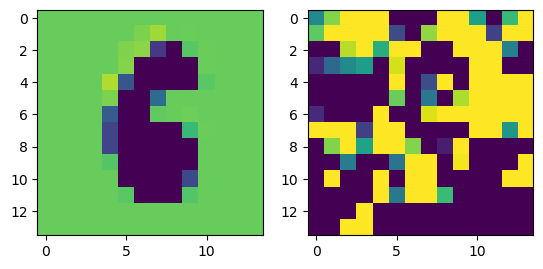

prediction: tensor([2, 6, 0]), tensor([1.7510, 1.7032, 1.4706]) groudtruth: 6
-0.13672113 0.119350836


<Figure size 640x480 with 0 Axes>

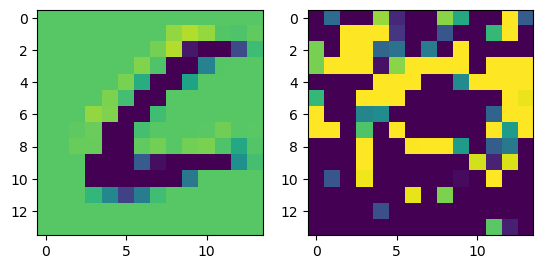

prediction: tensor([2, 7, 3]), tensor([2.1885, 1.6213, 0.5751]) groudtruth: 7
-0.14926797 0.17429224


<Figure size 640x480 with 0 Axes>

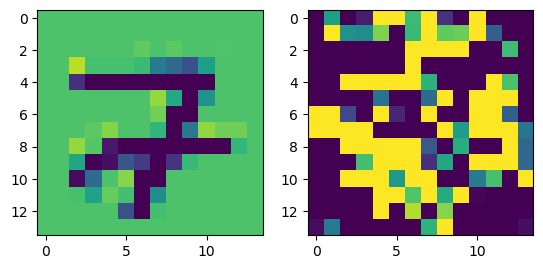

prediction: tensor([6, 8, 5]), tensor([0.9736, 0.9633, 0.3487]) groudtruth: 8
-0.13839728 0.18607673


<Figure size 640x480 with 0 Axes>

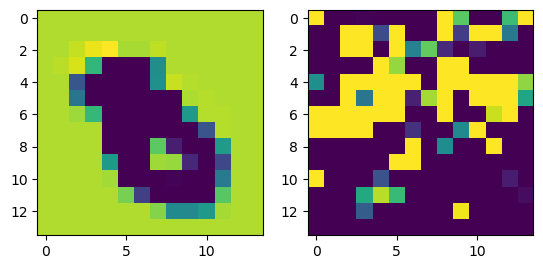

prediction: tensor([6, 4, 8]), tensor([1.2979, 0.8927, 0.7890]) groudtruth: 4
-0.1526143 0.15395652


<Figure size 640x480 with 0 Axes>

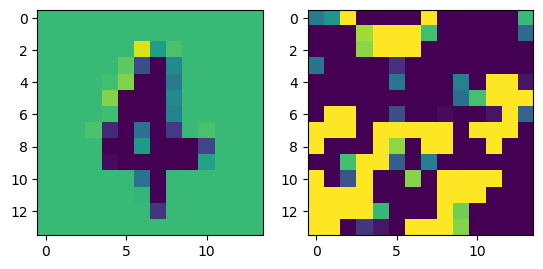

prediction: tensor([9, 4, 5]), tensor([1.9915, 1.5950, 0.4063]) groudtruth: 4
-0.1137656 0.18185005


<Figure size 640x480 with 0 Axes>

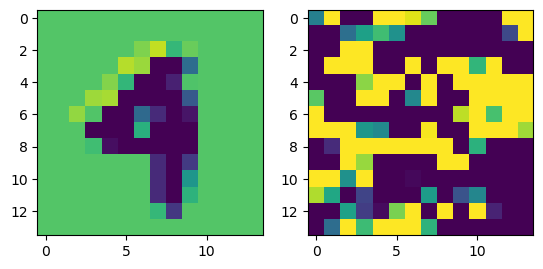

prediction: tensor([0, 2, 5]), tensor([1.4933, 0.6026, 0.3093]) groudtruth: 8
-0.12324488 0.14906842


<Figure size 640x480 with 0 Axes>

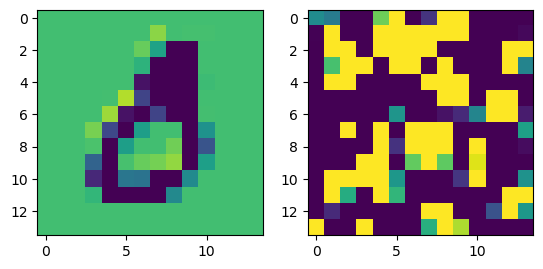

prediction: tensor([5, 3, 7]), tensor([1.2326, 1.0817, 0.4037]) groudtruth: 3
-0.1598416 0.13298881


<Figure size 640x480 with 0 Axes>

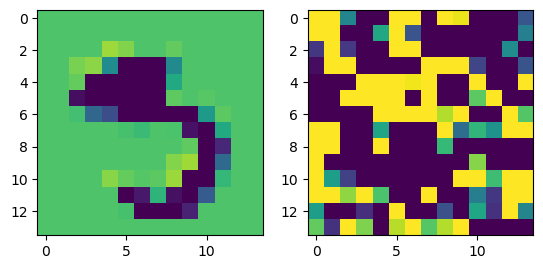

prediction: tensor([0, 6, 4]), tensor([2.4163, 1.2692, 0.1520]) groudtruth: 6
-0.15574753 0.18557504


<Figure size 640x480 with 0 Axes>

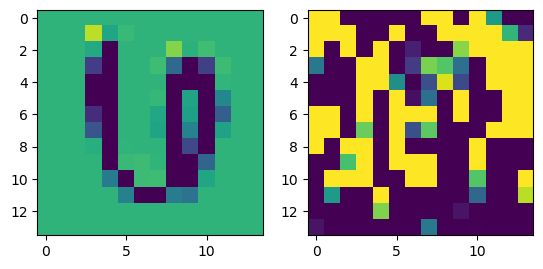

prediction: tensor([2, 7, 1]), tensor([1.2136, 1.2132, 0.8262]) groudtruth: 7
-0.13721472 0.13993537


<Figure size 640x480 with 0 Axes>

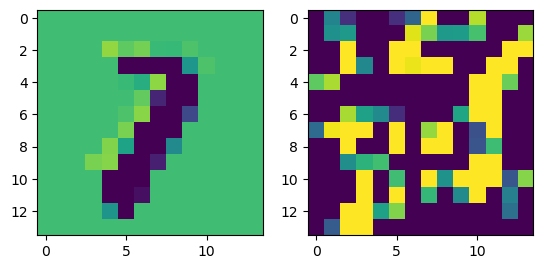

prediction: tensor([0, 2, 6]), tensor([1.1784, 0.5627, 0.4916]) groudtruth: 9
-0.18017983 0.114050075


<Figure size 640x480 with 0 Axes>

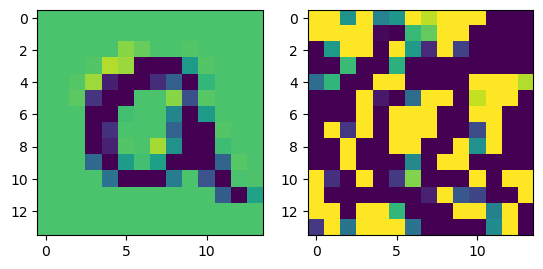

prediction: tensor([8, 7, 2]), tensor([1.5311, 1.0557, 0.6640]) groudtruth: 2
-0.16664028 0.110699296


<Figure size 640x480 with 0 Axes>

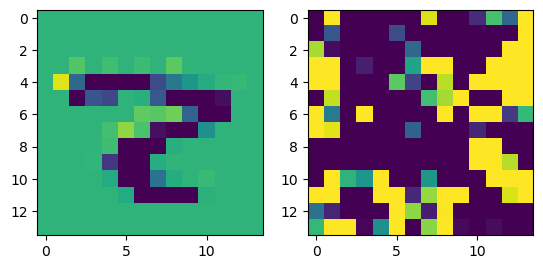

prediction: tensor([1, 4, 7]), tensor([1.5033, 1.4367, 0.4285]) groudtruth: 4
-0.15481907 0.18135744


<Figure size 640x480 with 0 Axes>

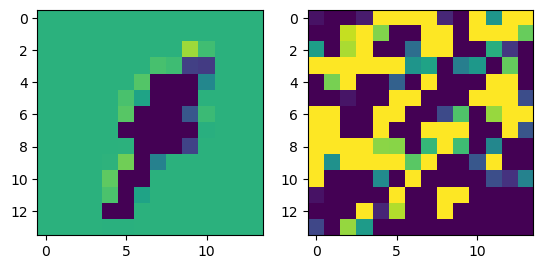

prediction: tensor([9, 4, 5]), tensor([1.8075, 1.1003, 0.2365]) groudtruth: 4
-0.18520474 0.18711782


<Figure size 640x480 with 0 Axes>

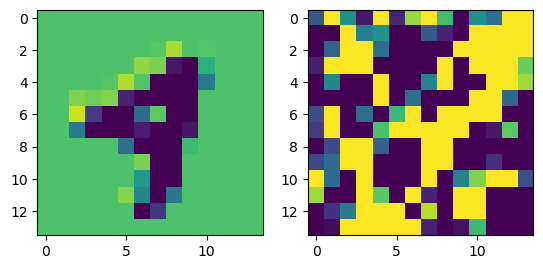

prediction: tensor([0, 8, 9]), tensor([1.3651, 0.8059, 0.6896]) groudtruth: 8
-0.14223665 0.13523644


<Figure size 640x480 with 0 Axes>

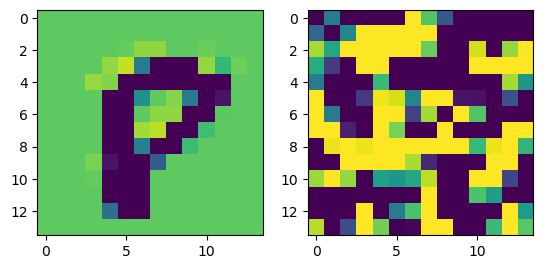

prediction: tensor([7, 2, 8]), tensor([1.2657, 0.7364, 0.6383]) groudtruth: 3
-0.1541475 0.15342712


<Figure size 640x480 with 0 Axes>

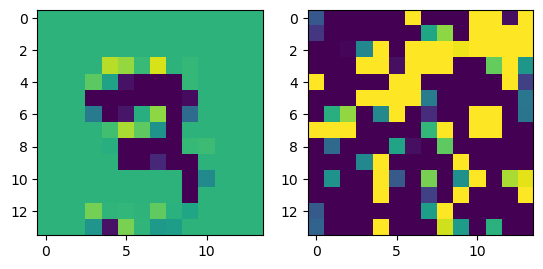

prediction: tensor([2, 6, 0]), tensor([1.4106, 0.9277, 0.8079]) groudtruth: 4
-0.16157496 0.14753021


<Figure size 640x480 with 0 Axes>

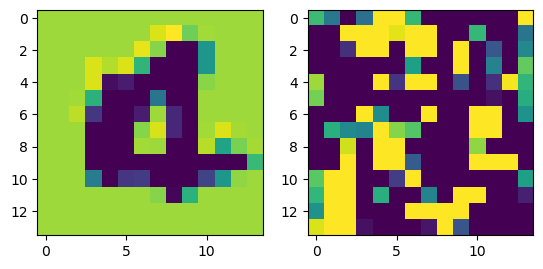

prediction: tensor([8, 5, 9]), tensor([1.5192, 0.7828, 0.2084]) groudtruth: 3
-0.116254926 0.13738118


<Figure size 640x480 with 0 Axes>

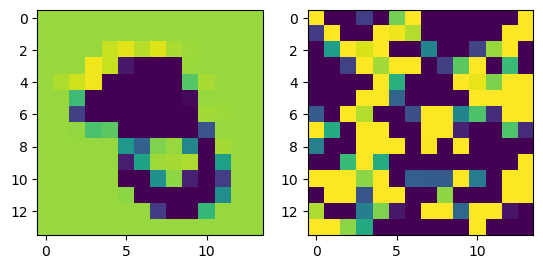

prediction: tensor([8, 5, 3]), tensor([1.1016, 0.9141, 0.9090]) groudtruth: 9
-0.1547029 0.19799444


<Figure size 640x480 with 0 Axes>

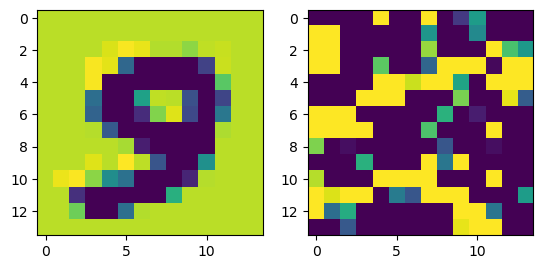

prediction: tensor([0, 8, 5]), tensor([1.6416, 1.2537, 0.3789]) groudtruth: 9
-0.14007455 0.15496549


<Figure size 640x480 with 0 Axes>

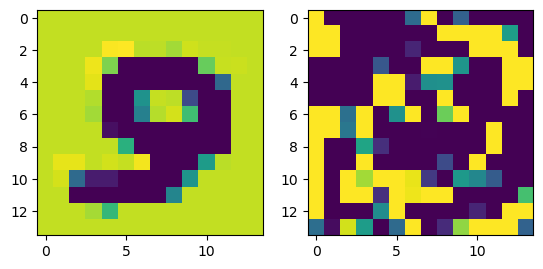

prediction: tensor([8, 2, 3]), tensor([1.6639, 1.4350, 0.2851]) groudtruth: 2
-0.15836501 0.1261966


<Figure size 640x480 with 0 Axes>

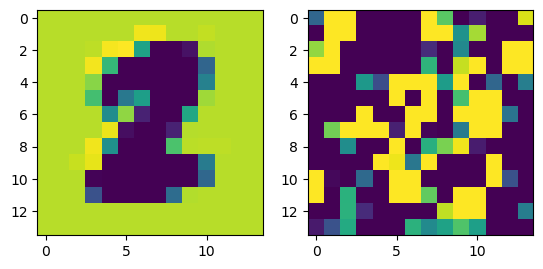

prediction: tensor([5, 8, 0]), tensor([1.0110, 0.6772, 0.4391]) groudtruth: 9
-0.16603088 0.11002676


<Figure size 640x480 with 0 Axes>

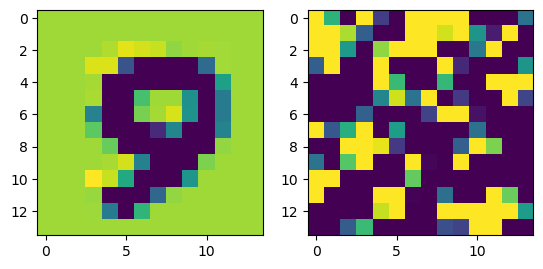

prediction: tensor([3, 5, 8]), tensor([0.8677, 0.4689, 0.4455]) groudtruth: 9
-0.15999258 0.15802702


<Figure size 640x480 with 0 Axes>

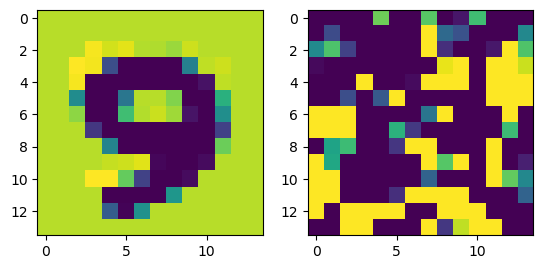

prediction: tensor([5, 8, 0]), tensor([0.9515, 0.6208, 0.6104]) groudtruth: 9
-0.14249122 0.12299224


<Figure size 640x480 with 0 Axes>

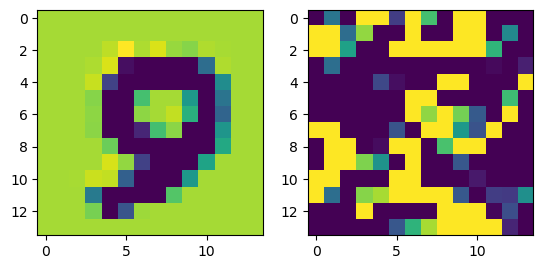

prediction: tensor([0, 8, 9]), tensor([2.2081, 0.2403, 0.1495]) groudtruth: 9
-0.13059682 0.13448778


<Figure size 640x480 with 0 Axes>

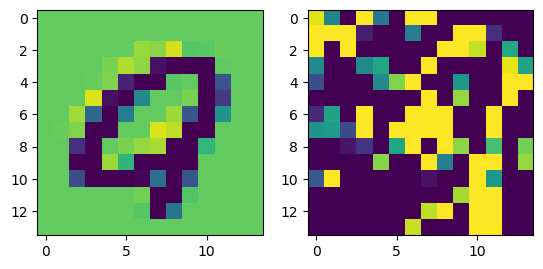

prediction: tensor([9, 5, 3]), tensor([1.1712, 1.1694, 0.7225]) groudtruth: 3
-0.10246134 0.14747769


<Figure size 640x480 with 0 Axes>

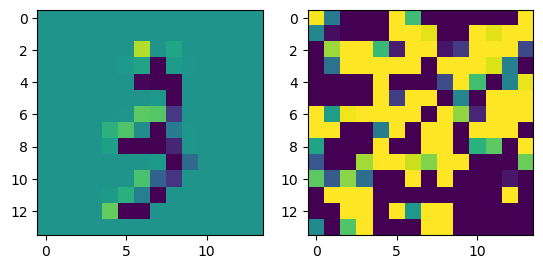

prediction: tensor([7, 9, 3]), tensor([1.9955, 1.6092, 0.1019]) groudtruth: 9
-0.13925529 0.15758981


<Figure size 640x480 with 0 Axes>

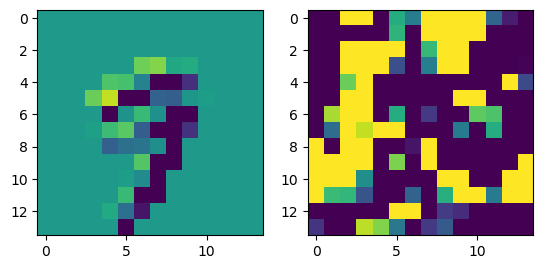

prediction: tensor([7, 0, 3]), tensor([2.0437, 1.3278, 0.5980]) groudtruth: 0
-0.1409412 0.13686734


<Figure size 640x480 with 0 Axes>

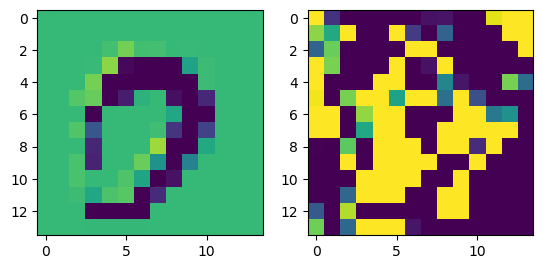

prediction: tensor([7, 9, 1]), tensor([1.7698, 1.2333, 0.2179]) groudtruth: 9
-0.14790493 0.1276548


<Figure size 640x480 with 0 Axes>

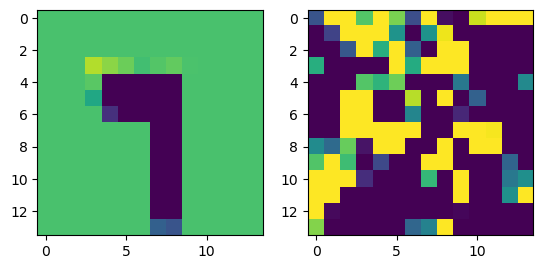

prediction: tensor([2, 7, 1]), tensor([1.1108, 0.7352, 0.7021]) groudtruth: 7
-0.14704323 0.1146365


<Figure size 640x480 with 0 Axes>

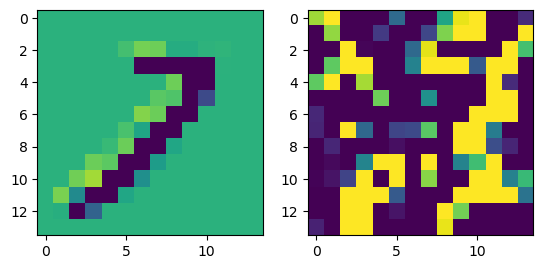

prediction: tensor([8, 4, 6]), tensor([1.7929, 0.3811, 0.1662]) groudtruth: 4
-0.14616734 0.16312703


<Figure size 640x480 with 0 Axes>

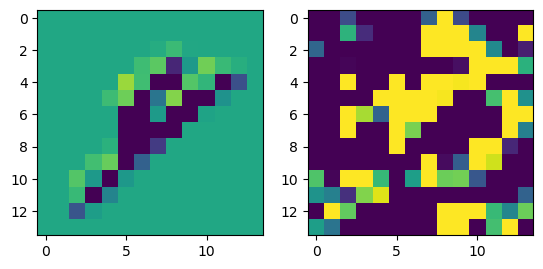

prediction: tensor([7, 2, 8]), tensor([1.4709, 1.1321, 0.8183]) groudtruth: 2
-0.13414073 0.15756127


<Figure size 640x480 with 0 Axes>

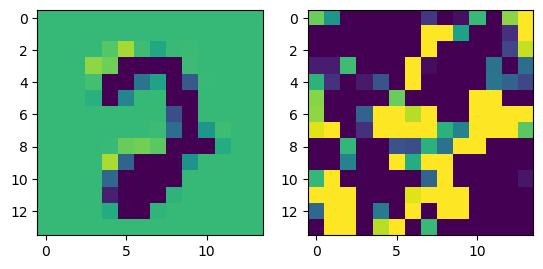

prediction: tensor([8, 5, 6]), tensor([1.6985, 1.2723, 0.3824]) groudtruth: 5
-0.13563865 0.11695681


<Figure size 640x480 with 0 Axes>

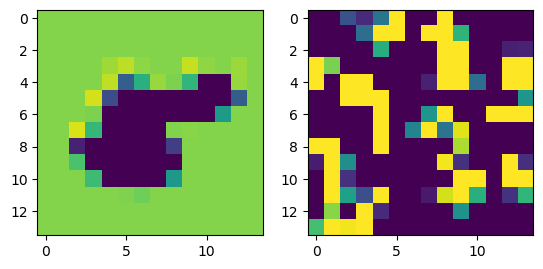

prediction: tensor([9, 2, 4]), tensor([1.0008, 0.9970, 0.7671]) groudtruth: 2
-0.10897303 0.16503742


<Figure size 640x480 with 0 Axes>

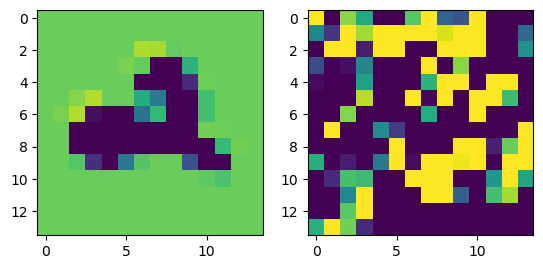

prediction: tensor([7, 3, 9]), tensor([1.4994, 0.7364, 0.7022]) groudtruth: 9
-0.09933972 0.22704804


<Figure size 640x480 with 0 Axes>

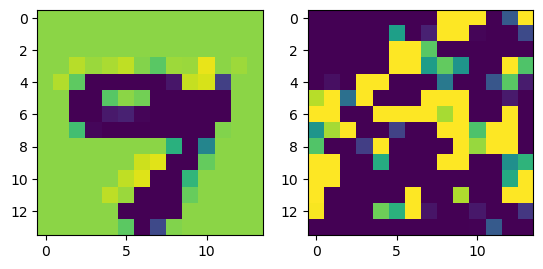

prediction: tensor([9, 4, 8]), tensor([1.0635, 0.7710, 0.4365]) groudtruth: 4
-0.114400566 0.12192537


<Figure size 640x480 with 0 Axes>

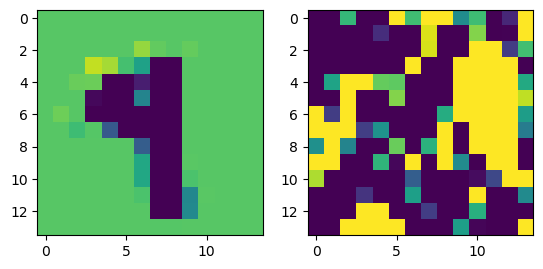

prediction: tensor([2, 3, 7]), tensor([1.8256, 1.4725, 1.1654]) groudtruth: 7
-0.14184254 0.16853318


<Figure size 640x480 with 0 Axes>

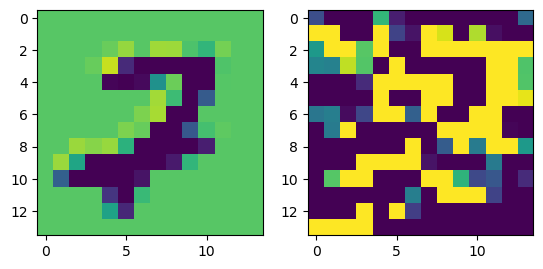

prediction: tensor([7, 0, 2]), tensor([2.3891, 0.7829, 0.5067]) groudtruth: 9
-0.14039975 0.16440155


<Figure size 640x480 with 0 Axes>

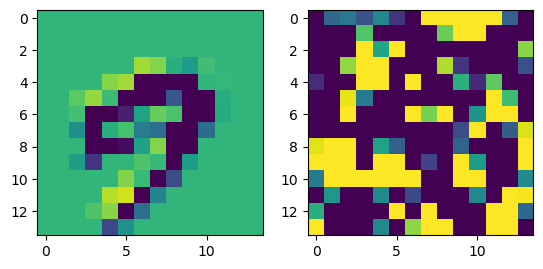

prediction: tensor([1, 3, 6]), tensor([0.7611, 0.6092, 0.5895]) groudtruth: 6
-0.14773643 0.16593613


<Figure size 640x480 with 0 Axes>

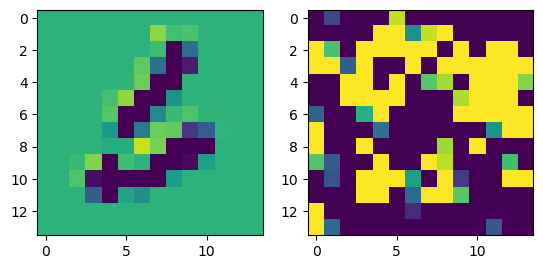

prediction: tensor([6, 5, 0]), tensor([1.8299, 1.1681, 0.1548]) groudtruth: 5
-0.13406509 0.13617101


<Figure size 640x480 with 0 Axes>

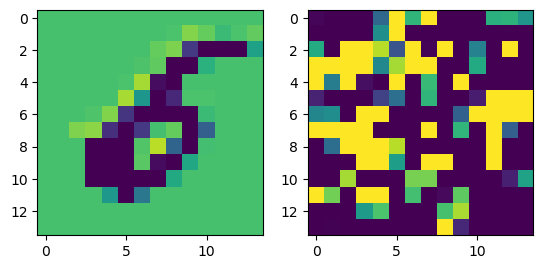

prediction: tensor([7, 9, 4]), tensor([1.9668, 0.9017, 0.0795]) groudtruth: 9
-0.15512252 0.16814597


<Figure size 640x480 with 0 Axes>

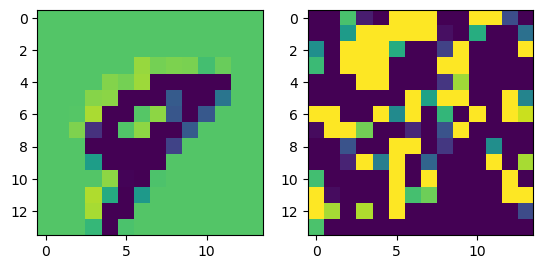

prediction: tensor([0, 2, 8]), tensor([1.5125, 1.1399, 0.4281]) groudtruth: 2
-0.16432786 0.14555974


<Figure size 640x480 with 0 Axes>

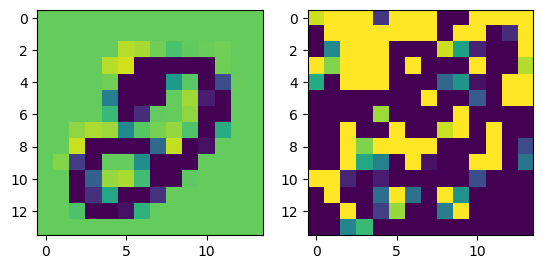

prediction: tensor([0, 5, 6]), tensor([1.4590, 1.3407, 0.5966]) groudtruth: 5
-0.11970347 0.0988581


<Figure size 640x480 with 0 Axes>

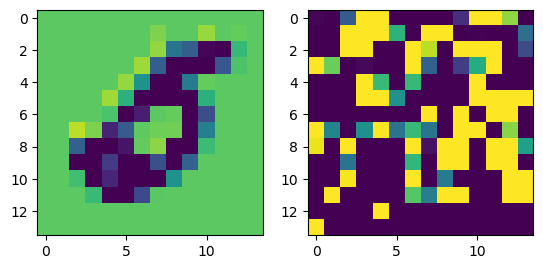

prediction: tensor([5, 6, 0]), tensor([2.0712, 2.0211, 0.1391]) groudtruth: 6
-0.15385276 0.17416173


<Figure size 640x480 with 0 Axes>

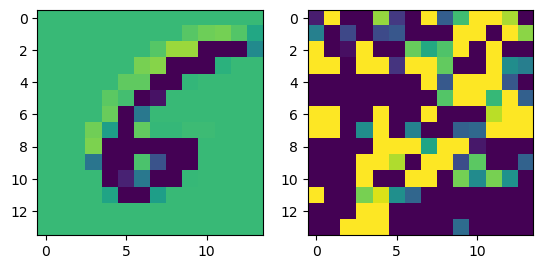

prediction: tensor([7, 9, 2]), tensor([2.4631, 0.4666, 0.2793]) groudtruth: 2
-0.1886447 0.14841618


<Figure size 640x480 with 0 Axes>

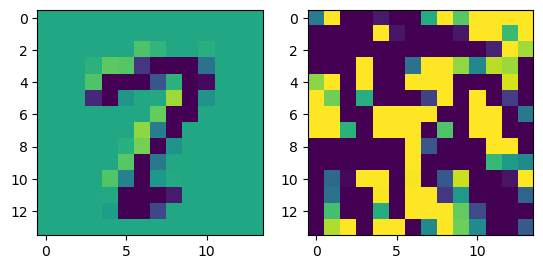

prediction: tensor([8, 7, 2]), tensor([1.5134, 0.8875, 0.7023]) groudtruth: 2
-0.13329571 0.20167655


<Figure size 640x480 with 0 Axes>

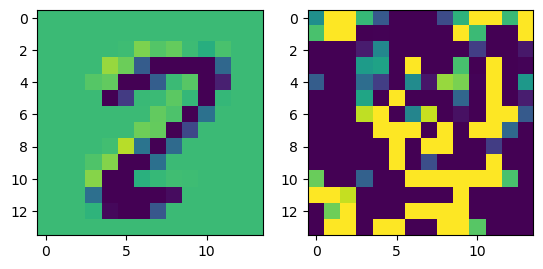

prediction: tensor([0, 6, 8]), tensor([1.9142, 1.3645, 1.0130]) groudtruth: 6
-0.14950323 0.14417128


<Figure size 640x480 with 0 Axes>

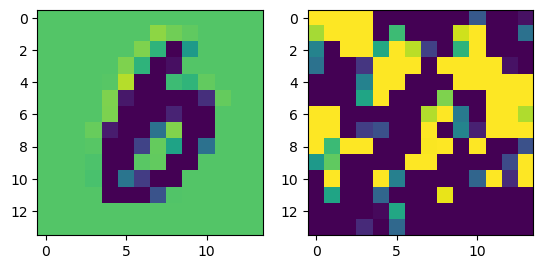

prediction: tensor([8, 2, 7]), tensor([2.2427, 0.8142, 0.3912]) groudtruth: 2
-0.14702404 0.12930298


<Figure size 640x480 with 0 Axes>

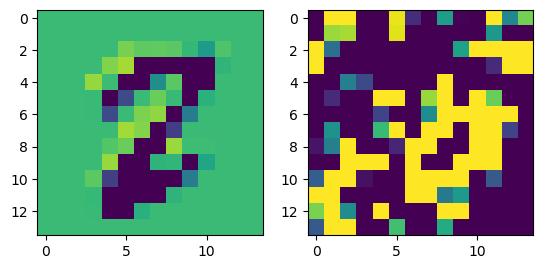

In [15]:
import matplotlib.pyplot as plt

for data, target in test_loader: 

    a1, a2, a3, a4 = forward_model(data)
    s1, s2, s3 = backward_model(target, use_act_derivative=True)
    # p = torch.argmax(a4, dim=-1)
    p = torch.topk(a4, k=3, dim=-1).indices
    v = torch.topk(a4, k=3, dim=-1).values

    for i1 in range(16):

        if p[i1][0] != target[i1]:

            i2 = 11
            print(f"prediction: {p[i1]}, {v[i1].detach()} groudtruth: {target[i1]}")

            plt.figure()
            fig, axes = plt.subplots(1,2)

            X = a1.detach().cpu()
            # X = X / X.norm()
            X = X.numpy()


            axes[0].imshow(X[i1,i2], vmin=-1, vmax=1)

            X = s1.detach().cpu()
            # X = X / X.norm()
            X = X.numpy()
            print(X[i1,i2].min(), X[i1,i2].max())

            axes[1].imshow(X[i1,i2], vmin=-0.0, vmax=0.03)
            plt.pause(0.2)
    # break

In [ ]:
## import matplotlib.pyplot as plt

backward_model = BackwardModel()
s1, s2, s3 = backward_model(target)

i1, i2 = 7, 2
X = s1.detach().cpu()
X = X / X.norm()
X = X.numpy()
print(X[i1,i2].min(), X[i1,i2].max())
plt.imshow(X[i1,i2])

In [ ]:
i1, i2 = 0, 6
X = a1.detach().cpu()
X = X / X.norm()
X = X.numpy()
print(X[i1,i2].min(), X[i1,i2].max())
plt.imshow(X[i1,i2])

In [ ]:
s2.shape

In [ ]:
  3%|██▍                                                                       | 1/30 [00:07<03:51,  7.99s/it]
Epoch: 0, Test Accuracy: 87.87%
  7%|████▉                                                                     | 2/30 [00:15<03:40,  7.86s/it]
Epoch: 1, Test Accuracy: 90.56%
 10%|███████▍                                                                  | 3/30 [00:23<03:30,  7.80s/it]
Epoch: 2, Test Accuracy: 92.84%
 13%|█████████▊                                                                | 4/30 [00:31<03:24,  7.85s/it]
Epoch: 3, Test Accuracy: 93.81%
 17%|████████████▎                                                             | 5/30 [00:39<03:19,  7.98s/it]
Epoch: 4, Test Accuracy: 93.88%
 20%|██████████████▊                                                           | 6/30 [00:47<03:13,  8.08s/it]
Epoch: 5, Test Accuracy: 94.7%
 23%|█████████████████▎                                                        | 7/30 [00:56<03:08,  8.18s/it]
Epoch: 6, Test Accuracy: 95.2%
 27%|███████████████████▋                                                      | 8/30 [01:04<02:59,  8.18s/it]
Epoch: 7, Test Accuracy: 95.58%
 30%|██████████████████████▏                                                   | 9/30 [01:12<02:49,  8.09s/it]
Epoch: 8, Test Accuracy: 95.54%
 33%|████████████████████████▎                                                | 10/30 [01:20<02:40,  8.04s/it]
Epoch: 9, Test Accuracy: 95.75%

In [ ]:
  3%|██▍                                                                       | 1/30 [00:08<04:02,  8.35s/it]
Epoch: 0, Test Accuracy: 89.26%
  7%|████▉                                                                     | 2/30 [00:16<03:46,  8.08s/it]
Epoch: 1, Test Accuracy: 91.56%
 10%|███████▍                                                                  | 3/30 [00:24<03:38,  8.08s/it]
Epoch: 2, Test Accuracy: 93.26%
 13%|█████████▊                                                                | 4/30 [00:32<03:28,  8.03s/it]
Epoch: 3, Test Accuracy: 94.13%
 17%|████████████▎                                                             | 5/30 [00:40<03:20,  8.01s/it]
Epoch: 4, Test Accuracy: 94.24%
 20%|██████████████▊                                                           | 6/30 [00:48<03:11,  7.97s/it]
Epoch: 5, Test Accuracy: 94.85%
 23%|█████████████████▎                                                        | 7/30 [00:56<03:04,  8.03s/it]
Epoch: 6, Test Accuracy: 95.5%
 27%|███████████████████▋                                                      | 8/30 [01:04<02:58,  8.10s/it]
Epoch: 7, Test Accuracy: 95.66%
 30%|██████████████████████▏                                                   | 9/30 [01:12<02:48,  8.03s/it]
Epoch: 8, Test Accuracy: 95.81%
 33%|████████████████████████▎                                                | 10/30 [01:20<02:41,  8.05s/it]
Epoch: 9, Test Accuracy: 95.95%